<a href="https://colab.research.google.com/github/ankishb/fun-projects/blob/master/final_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/ankishb/fun-projects.git

Cloning into 'fun-projects'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 52 (delta 18), reused 25 (delta 8), pack-reused 0
Unpacking objects: 100% (52/52), done.


In [0]:
file_path = 'fun-projects/amazon-ml/'

In [0]:
from tqdm import tqdm
import pandas as pd
import numpy as np
tqdm.pandas()
import matplotlib.pyplot as plt
%matplotlib inline

import os, gc, json, operator, re
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)


sns.set(context='notebook', style='whitegrid', 
        palette='deep', font='sans-serif', 
        font_scale=2, color_codes=True, rc=None)

Text preprocessing: 

1.   Convert all words to Lower Case 
2.   Replace shortcut words with thoer corresponding word, i used contraction mapping text file to do this.
3.   Extra Space removal
4.   Punctualtion removal, to do this, i have included some special punctuation too, based on the dataset.
5. Digit and other special character removal.

After all these step, it will give convergence of around 94.7% from 71.3% on glove embedding.



In [4]:
train = pd.read_csv(file_path+'Dataset/train.csv')
test  = pd.read_csv(file_path+'Dataset/test.csv')
sub   = pd.read_csv(file_path+'Dataset/Sample_Submission.csv')
print(train.shape, test.shape, sub.shape)


train.rename(columns={'Review Text':'text', 'Review Title':'title'}, inplace=True)
test.rename(columns={'Review Text':'text', 'Review Title':'title'}, inplace=True)

df = train.append(test, ignore_index=True)
df['save_text']  = df['text']
df['save_title'] = df['title']

df['text']  = df['text'].str.lower()
df['title'] = df['title'].str.lower()

with open(file_path+'contraction_mapping.txt') as f:
    contraction_mapping = json.loads(f.read())

def correct_contraction(x, dic):
    for word in dic.keys():
        if word in x:
            x = x.replace(word, dic[word])
    return x

df['text']  = df['text'].progress_apply(lambda x: correct_contraction(x, contraction_mapping))
df['title'] = df['title'].progress_apply(lambda x: correct_contraction(x, contraction_mapping))



 49%|████▊     | 4129/8512 [00:00<00:00, 41277.25it/s]

(5959, 3) (2553, 2) (5, 3)


100%|██████████| 8512/8512 [00:00<00:00, 118655.95it/s]


In [5]:
with open(file_path+'punctuation.txt', 'r') as f:
    extra_punct = json.loads(f.read())

import string
my_punct = list(string.punctuation)
all_punct = list(set(my_punct + extra_punct))

special_punc_mappings = {"—": "-", "–": "-", "_": "-", '”': '"', "″": '"', '“': '"', '•': '.', '−': '-',
                         "’": "'", "‘": "'", "´": "'", "`": "'", '\u200b': ' ', '\xa0': ' ','،':'','„':'',
                         '…': ' ... ', '\ufeff': ''}

def spacing_punctuation(text):
    """
    add space before and after punctuation and symbols
    """
    for punc in all_punct:
        if punc in text:
            text = text.replace(punc, f' {punc} ')
    return text

def clean_special_punctuations(text):
    for punc in special_punc_mappings:
        if punc in text:
#             print(punc)
            text = text.replace(punc, special_punc_mappings[punc])
    return text



def preprocess(text):
    text = spacing_punctuation(text)
    text = clean_special_punctuations(text)
    return text


df["text"] = df["text"].progress_apply(preprocess)
df['text'] = df['text'].str.replace(r'\b\w\b','').str.replace(r'\s+', ' ')
df['text'].replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)
df['text'].replace({'  ':' '}, regex=True, inplace=True)

df["title"] = df["title"].progress_apply(preprocess)
df['title'] = df['title'].str.replace(r'\b\w\b','').str.replace(r'\s+', ' ')
df['title'].replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)
df['title'].replace({'  ':' '}, regex=True, inplace=True)

import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r'@[a-zA-Z0-9_]+', '', text)   
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)   
    text = re.sub(r'www.[^ ]+', '', text)  
    text = re.sub(r'[a-zA-Z0-9]*www[a-zA-Z0-9]*com[a-zA-Z0-9]*', '', text)  
    text = re.sub(r'[^a-zA-Z]', ' ', text)   
    text = [token for token in text.split() if len(token) > 2]
    text = ' '.join(text)
    return text

df['text']   = df['text'].progress_apply(clean_text)
df['title']  = df['title'].progress_apply(clean_text)

def clean_text(x):
    x = str(x)
    for punct in "/-'":
        x = x.replace(punct, ' ')
    for punct in '&':
        x = x.replace(punct, f' {punct} ')
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
        x = x.replace(punct, '')
    return x

df['text'] = df['text'].progress_apply(clean_text)
df['title'] = df['title'].progress_apply(clean_text)

train1 = df[:train.shape[0]]
test1  = df[train.shape[0]:]
train1.shape, test1.shape

100%|██████████| 8512/8512 [00:00<00:00, 105172.36it/s]


((5959, 5), (2553, 5))

Combine duplicates row with same Review text and Review Title and prepare **multilabel target set** .

In [6]:
train1['topic'] = train1['topic'].apply(lambda x: "_".join(x.split(" ")))
gp = train1.groupby(['text','title']).agg({
        "topic": lambda x: " ".join(x.values)
    })
train2 = pd.DataFrame(gp.reset_index())

test1['topic'] = 'null'
gp = test1.groupby(['text','title']).agg({
        "topic": lambda x: " ".join(x.values)
    })
test2 = pd.DataFrame(gp.reset_index())

# train2.head().append(test2.head())
print(train2.shape, test2.shape)

(4210, 3) (1773, 3)


In [7]:
train3 = pd.merge(train1[['text','title']], train2, how='left')
test3  = pd.merge(test1[['text','title']], test2, how='left')

train3['labels'] = train3['topic'].apply(lambda x: len(x.split(" ")))
test3['labels']  = test3['topic'].apply(lambda x: len(x.split(" ")))

# train3.head().append(test3.head())
print(train3.shape, test3.shape)

(5959, 4) (2553, 4)


Prepare Label Encoding of class to digit

In [8]:
df1 = train2.append(test2, ignore_index=True)

print("Old table : ", df.shape, train.shape, test.shape) 
print("New Table : ", df1.shape, train2.shape, test2.shape)


labels = train1['topic'].values

train['target'] = train['topic'].astype('category').cat.codes
train['target'] = train['target'].astype('int')

def get_mapping(df, col_name):
    cat_codes = df[col_name].astype('category')
    
    class_mapping = {}
    i = 0
    for col in cat_codes.cat.categories:
        class_mapping[col] = i
        i += 1
    
    class_mapping_reverse = {}
    for key, value in class_mapping.items():
        class_mapping_reverse[value] = key

    return class_mapping, class_mapping_reverse

cl_map, cl_map_inv = get_mapping(train, 'topic')


cl_map1 = {}
for key, value in cl_map.items():
    cl_map1["_".join(key.split(" "))] = value
    


Old table :  (8512, 5) (5959, 3) (2553, 2)
New Table :  (5983, 3) (4210, 3) (1773, 3)


In [10]:
cl_map_inv

{0: 'Allergic',
 1: 'Bad Taste/Flavor',
 2: 'Color and texture',
 3: 'Customer Issues',
 4: 'Customer Service',
 5: "Didn't Like",
 6: 'Expiry',
 7: 'False Advertisement',
 8: 'Hard to Chew',
 9: 'Inferior to competitors',
 10: 'Ingredients',
 11: 'Not Effective',
 12: 'Packaging',
 13: 'Pricing',
 14: 'Quality/Contaminated',
 15: 'Shipment and delivery',
 16: 'Smells Bad',
 17: 'Texture',
 18: 'Too Sweet',
 19: 'Too big to swallow',
 20: 'Wrong Product received'}

Text(0.5, 1.0, 'Classes Distribution of dataset')

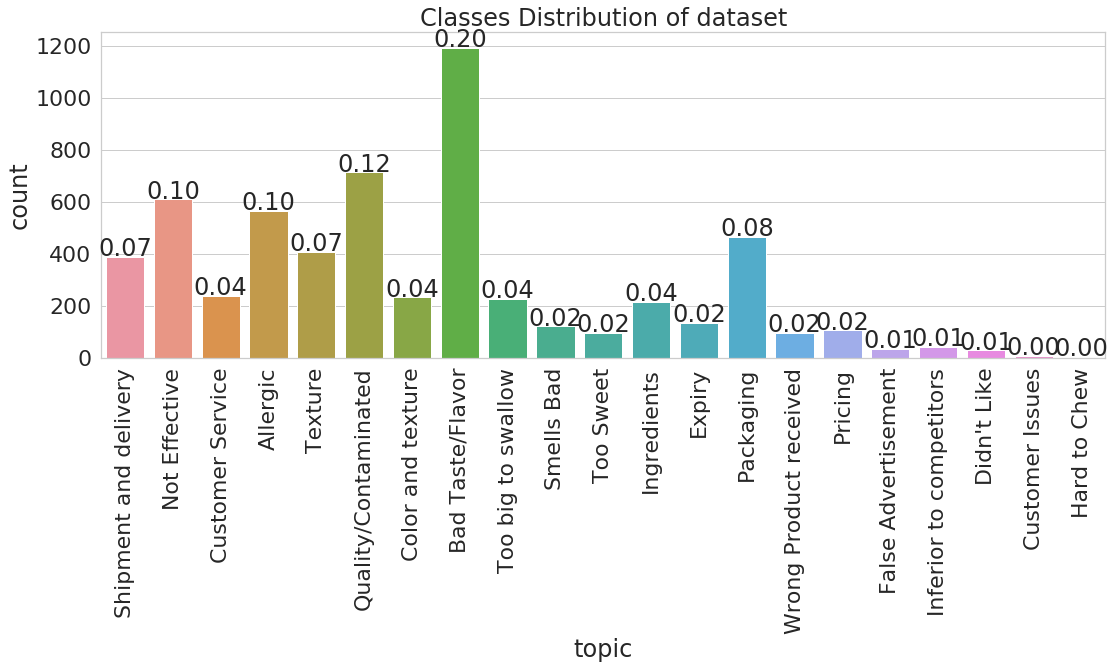

In [148]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.countplot(train['topic'], ax=ax)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
total = train.shape[0]
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 3, '{:1.2f}'.format(height/total), ha="center")

ax.set_title("Classes Distribution of dataset")

Text(0.5, 1.0, 'word length distribution in Review Text')

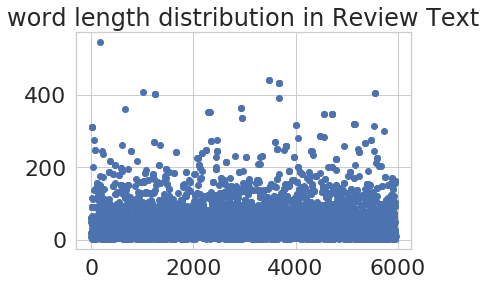

In [14]:
train_len = train['text'].apply(lambda x: len(x.split(" ")))
plt.scatter(range(train.shape[0]), train_len)
plt.title("word length distribution in Review Text")

In [15]:
def get_quantile(df, col, q1, q2):
    """compute quantile range
    args:
        col: col name
        q1: lower quantile percentile
        q2: upper quantile percentile
    """
    df1 = df[[col]].dropna()
    lower_bound = np.percentile(df1, q=q1)
    upper_bound = np.percentile(df1, q=q2)
    lower_bound = np.round(lower_bound,3)
    upper_bound = np.round(upper_bound, 3)
    min_ = np.round(np.min(df1[col]), 3)
    max_ = np.round(np.max(df1[col]), 3)
    print("Col: {4:<15} min: {0:<10} max: {1:<10} low: {2:<10} high: {3:<10}".format(min_, max_, lower_bound, upper_bound, col))

train['len'] = train['text'].apply(lambda x: len(x.split(" ")))
get_quantile(train, 'len', 5, 95)
get_quantile(train, 'len', 1, 96)
get_quantile(train, 'len', 1, 97)
get_quantile(train, 'len', 1, 98)
get_quantile(train, 'len', 1, 99)
train.drop('len', axis=1, inplace=True)

Col: len             min: 1          max: 546        low: 5.0        high: 153.1     
Col: len             min: 1          max: 546        low: 2.0        high: 164.0     
Col: len             min: 1          max: 546        low: 2.0        high: 185.26    
Col: len             min: 1          max: 546        low: 2.0        high: 215.0     
Col: len             min: 1          max: 546        low: 2.0        high: 260.84    


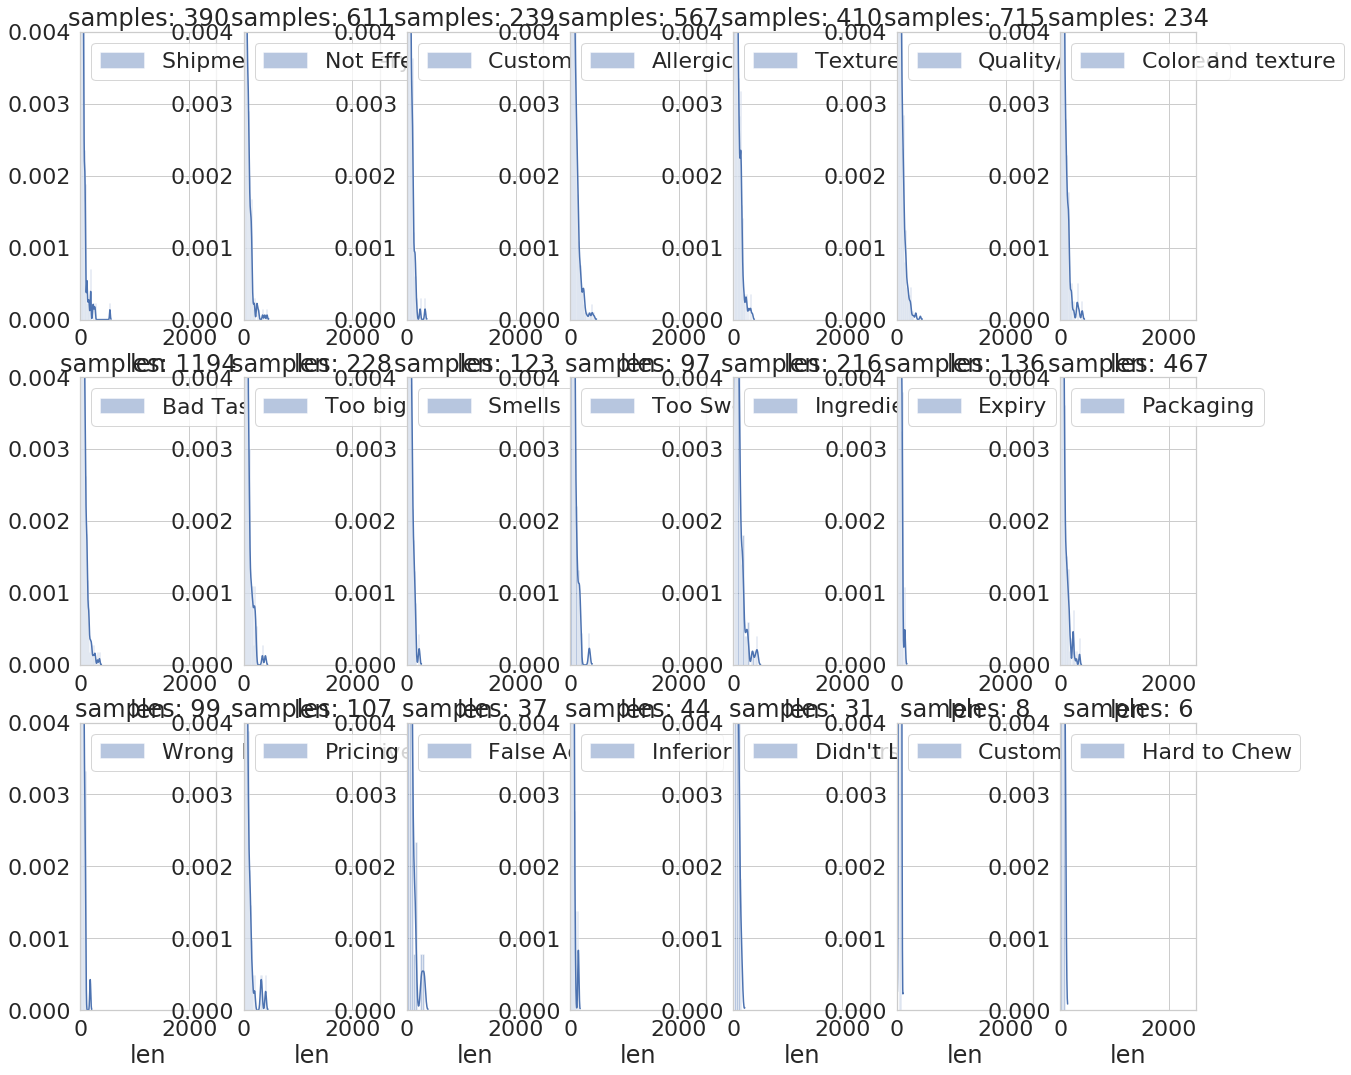

In [18]:
train['len'] = train['text'].apply(lambda x: len(x.split(" ")))

fig, ax = plt.subplots(3,7, figsize=(20,18))
axes = ax.flatten()
all_topics = list(train['topic'].unique())
for topic, ax_ in zip(all_topics, axes):
    sns.distplot(train[train['topic'] == topic]['len'], label=topic, ax=ax_)
    ax_.legend()
    ax_.set_title('samples: '+str(train[train['topic'] == topic].shape[0]))
    ax_.set_xlim([0,2500])
    ax_.set_ylim([0., 0.0040])
train.drop('len', axis=1, inplace=True)

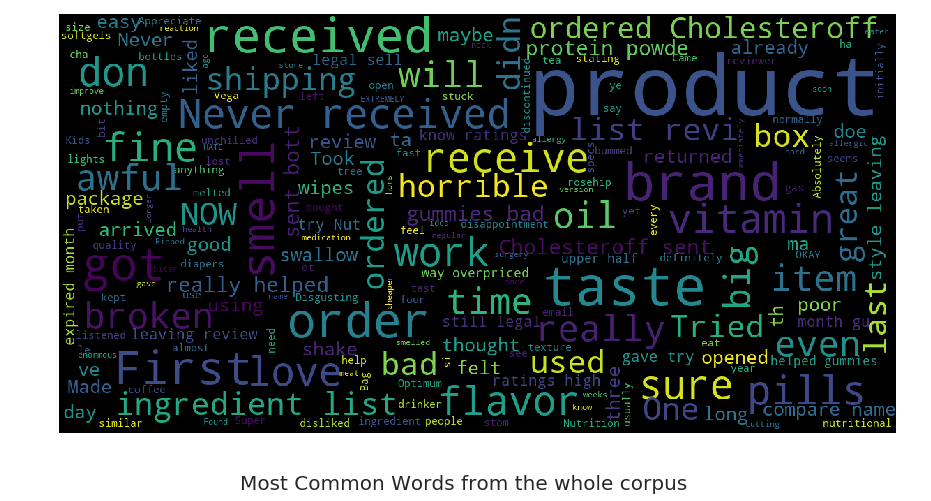

In [19]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    return wordcloud


wc1 = show_wordcloud(train['text'],'Most Common Words from the whole corpus')

Text(0.5, 1.0, 'Most common occured words')

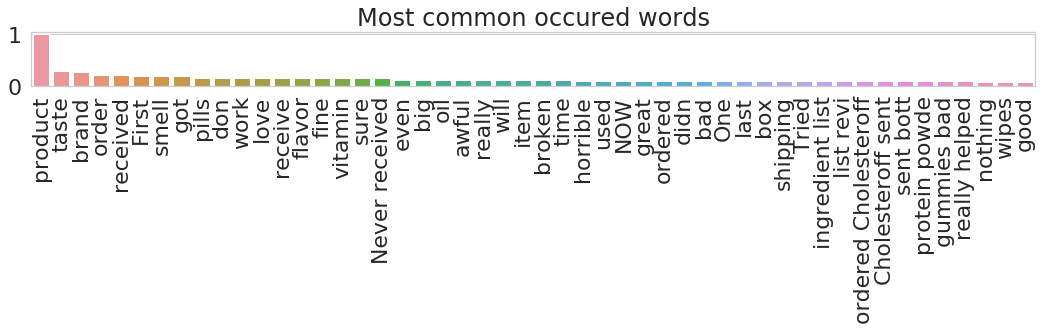

In [20]:
fig, ax = plt.subplots(figsize=(18, 1))
sns.barplot(list(wc1.words_.keys())[:50], list(wc1.words_.values())[:50], ax=ax)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
    tick.set_fontsize(22)
ax.set_title("Most common occured words")

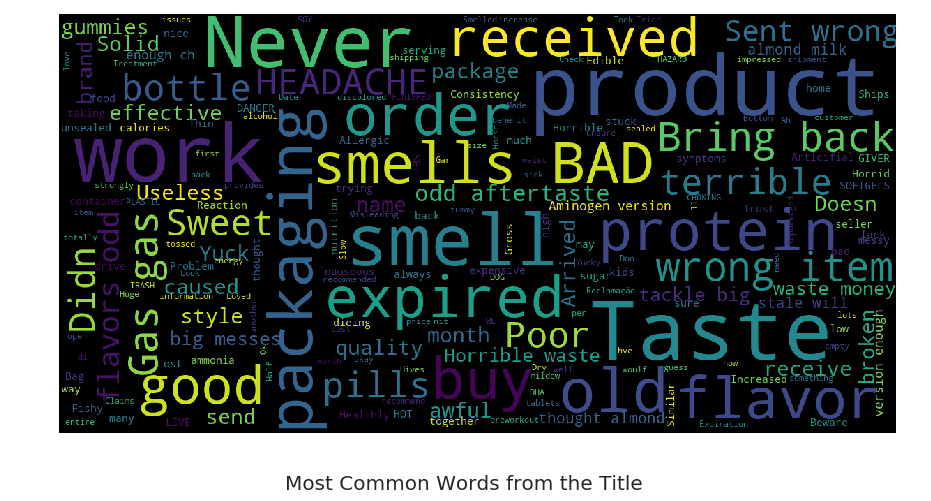

In [21]:
wc1 = show_wordcloud(train['title'],'Most Common Words from the Title')

Text(0.5, 1.0, 'Most common occured words in Title')

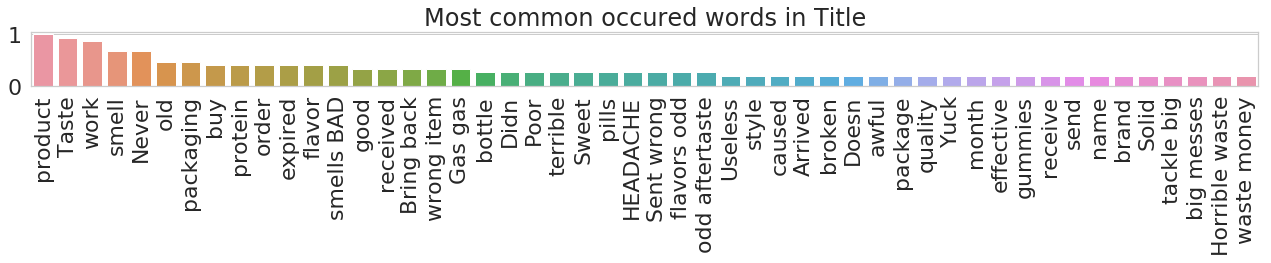

In [23]:
fig, ax = plt.subplots(figsize=(22, 1))
sns.barplot(list(wc1.words_.keys())[:50], list(wc1.words_.values())[:50], ax=ax)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
    tick.set_fontsize(22)
ax.set_title("Most common occured words in Title")

In [11]:
labels = train2['topic'].values
lt = np.zeros((df1.shape[0], 21))
j = -1
for key, value in cl_map1.items():
    j += 1
    for i, label in enumerate(labels):
#         print(label)
        if key in label:
            lt[i][j] = 1

print(lt.sum(axis=0))
l_table = pd.DataFrame(data=lt, columns=list(cl_map1.keys()))
l_table = l_table.astype('int')
print(l_table.shape)
# l_table.head()

[ 567. 1192.  233.    8.  239.   31.  135.   37.    6.   44.  215.  605.
  466.  107.  712.  387.  123.  410.   97.  228.   99.]
(5983, 21)


class count:  [1773 2907  959  277   53   11    3]
class wise:   [ 567 1194  234    8  239   31  136   37    6   44  216  611  467  107
  715  390  123  410   97  228   99]


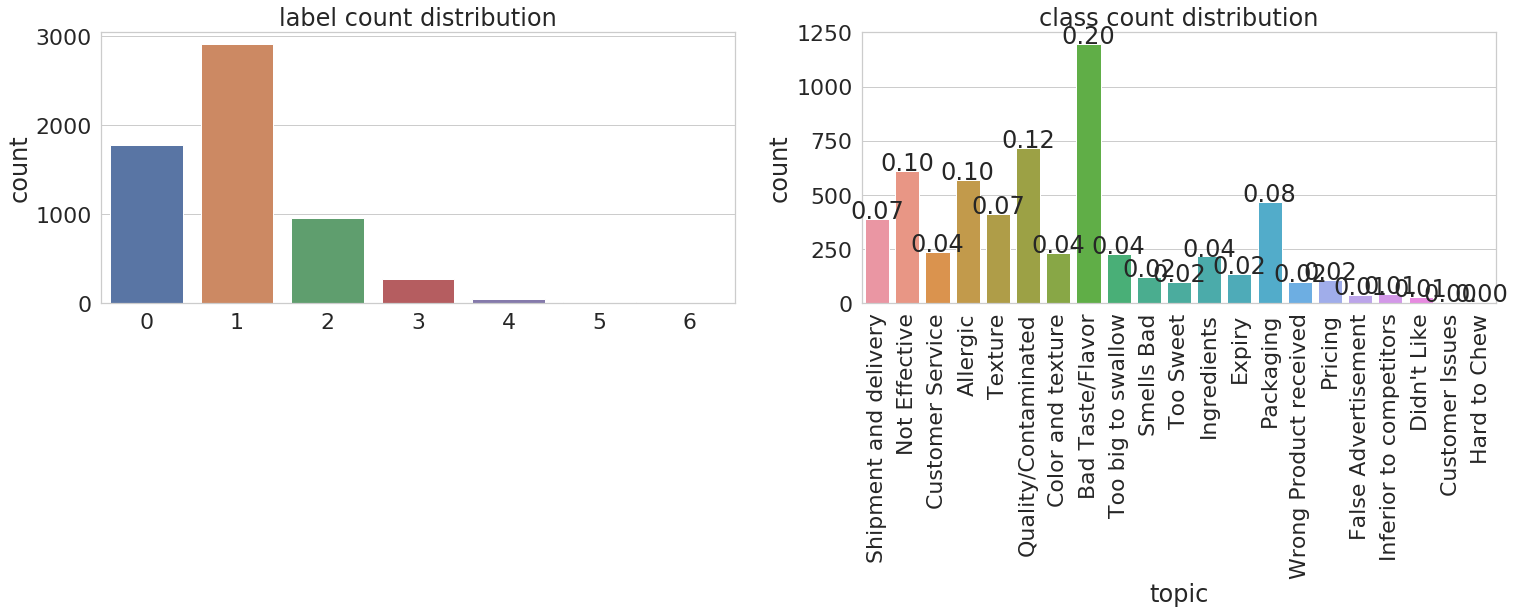

In [12]:
len1 = l_table.sum(axis=1)
fig, ax = plt.subplots(1,2,figsize=(25,5))
print("class count: ", np.bincount(len1))
print("class wise:  ", np.bincount(train['target']))

sns.countplot(len1, ax=ax[0])
ax[0].set_title("label count distribution")
sns.countplot(train['topic'], ax=ax[1])
ax[1].set_title("class count distribution")
for tick in ax[1].get_xticklabels():
    tick.set_rotation(90)
total = train.shape[0]
for p in ax[1].patches:
    height = p.get_height()
    ax[1].text(p.get_x()+p.get_width()/2., height + 3, '{:1.2f}'.format(height/total), ha="center")

In [0]:
import gc
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF

def tfidf_feature(train, test, col_name, min_df=3, analyzer='word', 
                  token_pattern=r'\w{1,}', ngram=3, stopwords='english', 
                  n_component=120, decom_flag=False, which_method='svd', 
                  max_features=None, feat_col_name='svd'):

    tfv = TfidfVectorizer(min_df=min_df,  max_features=max_features, 
                strip_accents='unicode', analyzer=analyzer, max_df=0.95, 
                token_pattern=token_pattern, ngram_range=(1, ngram), 
                use_idf=1, smooth_idf=1, sublinear_tf=1,
                stop_words = stopwords)

    complete_df = pd.concat([train[col_name], test[col_name]], axis=0)
#         return complete_df
#         print(complete_df.shape, complete_df.columns)

    tfv.fit(list(complete_df[:].values))

    if decom_flag is False:
        train_tfv =  tfv.transform(train[col_name].values.ravel()) 
        test_tfv  = tfv.transform(test[col_name].values.ravel())

        del complete_df
        gc.collect()
        return train_tfv, test_tfv, tfv
    else:
        complete_tfv = tfv.transform(complete_df[:].values.ravel())
        
        if which_method is 'svd':
            svd = TruncatedSVD(n_components=n_component)
            svd.fit(complete_tfv)
            complete_dec = svd.transform(complete_tfv)
        else:
            nmf = NMF(n_components=n_component, random_state=1234, alpha=0, l1_ratio=0)
            nmf.fit(complete_tfv)            
            complete_dec = nmf.fit_transform(complete_tfv)            
        
        
        complete_dec = pd.DataFrame(data=complete_dec)
        complete_dec.columns = [feat_col_name+'_'+str(i) for i in range(n_component)]

        train_dec = complete_dec.iloc[:train.shape[0]]
        test_dec = complete_dec.iloc[train.shape[0]:].reset_index(drop=True)

        del complete_dec, complete_df
        gc.collect()
        print("="*15, " done ", "="*15)
        return train_dec, test_dec, complete_tfv, tfv

def countvect_feature(train, test, col_name, min_df=3, 
                      analyzer='word', token_pattern=r'\w{1,}', 
                      ngram=3, stopwords='english', max_features=None):

    ctv = CountVectorizer(min_df=min_df,  max_features=max_features, 
                strip_accents='unicode', analyzer=analyzer, 
                token_pattern=token_pattern, ngram_range=(1, ngram), 
                stop_words = stopwords)

    complete_df = pd.concat([train[col_name], test[col_name]], axis=0)
    ctv.fit(list(complete_df[:].values))

    train_tf =  ctv.transform(train[col_name].values.ravel()) 
    test_tf  = ctv.transform(test[col_name].values.ravel())

    del complete_df
    gc.collect()
    return train_tf, test_tf, ctv


def get_count_vectorizer(df, col_name, min_df=3, analyzer='word', stopwords='english', 
                     token_pattern=r'\w{1,}', ngram=3, max_features=None):
    ctv = CountVectorizer(min_df=min_df,  max_features=max_features, 
                strip_accents='unicode', analyzer=analyzer, 
                token_pattern=token_pattern, ngram_range=(1, ngram), 
                stop_words = stopwords)

    ctv.fit(list(df[col_name].values))

    df_new =  ctv.transform(df[col_name].values.ravel()) 
    return df_new


def get_tfidf_feature(df, col_name, min_df=3, analyzer='word', stopwords='english',
                  token_pattern=r'\w{1,}', ngram=3, max_features=None):

    tfv = TfidfVectorizer(min_df=min_df,  max_features=max_features, 
                strip_accents='unicode', analyzer=analyzer, max_df=0.95, 
                token_pattern=token_pattern, ngram_range=(1, ngram), 
                use_idf=1, smooth_idf=1, sublinear_tf=1,
                stop_words = stopwords)

    tfv.fit(list(df[col_name].values))
    df_new =  tfv.transform(df[col_name].values.ravel()) 
    
    return df_new



In [25]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2019-08-11 15:08:24--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-08-11 15:08:24--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-08-11 15:08:24--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [26]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [27]:
!ls

fun-projects	   glove.6B.200d.txt  glove.6B.50d.txt	sample_data
glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip


In [28]:
embeddings_index = {}
f = open('glove.6B.300d.txt')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

400000it [00:31, 12517.90it/s]

Found 400000 word vectors.


In [29]:
print(train2.shape, test2.shape)

df1['topic1'] = df1['topic']
df1['topic'] = df1['topic1'].apply(lambda x: x.split(" ")[0])
train4 = df1[:train2.shape[0]]
test4  = df1[train2.shape[0]:]
train4.drop('topic1', axis=1, inplace=True)
test4.drop('topic1', axis=1, inplace=True)
print(train4.shape, test4.shape)


df3 = train4.append(test4, ignore_index=True)
print(df3.shape)


(4210, 3) (1773, 3)
(4210, 3) (1773, 3)
(5983, 3)


In [30]:
train4.shape, df3.shape, train4.columns

((4210, 3), (5983, 3), Index(['text', 'title', 'topic'], dtype='object'))

In [0]:
train4['target'] = train4['topic'].astype('category').cat.codes
train4['target'] = train4['target'].astype('int')

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

cv = CountVectorizer(max_df=0.97,min_df=2,stop_words='english')
term_matrix = cv.fit_transform(df3['title'])
# print(term_matrix)

topic moddeling using 10 component

In [35]:
lda = LatentDirichletAllocation(n_components=10, n_jobs=4)
lda.fit(term_matrix)

topic_word_dict = {}
for index,topic in enumerate(lda.components_):
    words = [cv.get_feature_names()[i] for i in topic.argsort()[-5:]]
    topic_word_dict[index] = words
    print('Top words for topic {}'.format(index))
    print(words)
    print('-'*120)

Top words for topic 0
['sent', 'bottle', 'good', 'broken', 'buy']
------------------------------------------------------------------------------------------------------------------------
Top words for topic 1
['poor', 'like', 'quality', 'tastes', 'does']
------------------------------------------------------------------------------------------------------------------------
Top words for topic 2
['delivered', 'wrong', 'product', 'item', 'received']
------------------------------------------------------------------------------------------------------------------------
Top words for topic 3
['receive', 'expired', 'packaging', 'did', 'product']
------------------------------------------------------------------------------------------------------------------------
Top words for topic 4
['reaction', 'allergic', 'delivery', 'work', 'did']
------------------------------------------------------------------------------------------------------------------------
Top words for topic 5
['price', 'aw

Text(0.5, 1.0, 'topics distribution')

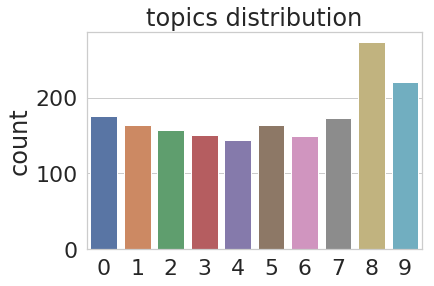

In [49]:
ts_feat = term_matrix[-test4.shape[0]:]
print(ts_feat.shape)
topics_ = lda.transform(ts_feat)

test_topics = []
for topic in topics_:
    test_topics.append(np.argsort(topic)[-1])
    
sns.countplot(test_topics)
plt.title("topics distribution")

topic modelling using 21 component and then we cluser the topics

In [50]:
lda = LatentDirichletAllocation(n_components=21, n_jobs=4)
lda.fit(term_matrix)

topic_word_dict = {}
for index,topic in enumerate(lda.components_):
    words = [cv.get_feature_names()[i] for i in topic.argsort()[-5:]]
    topic_word_dict[index] = words
    print('Top words for topic {}'.format(index))
    print(words)
    print('-'*120)

Top words for topic 0
['return', 'meh', 'nasty', 'delivered', 'delivery']
------------------------------------------------------------------------------------------------------------------------
Top words for topic 1
['flavor', 'new', 'huge', 'yuck', 'stomach']
------------------------------------------------------------------------------------------------------------------------
Top words for topic 2
['purchase', 'love', 'got', 'package', 'shipping']
------------------------------------------------------------------------------------------------------------------------
Top words for topic 3
['works', 'sent', 'wrong', 'item', 'horrible']
------------------------------------------------------------------------------------------------------------------------
Top words for topic 4
['used', 'sure', 'difference', 'expiration', 'date']
------------------------------------------------------------------------------------------------------------------------
Top words for topic 5
['effective', '

(4210, 1245)


Text(0.5, 1.0, 'topics distribution for training dataset')

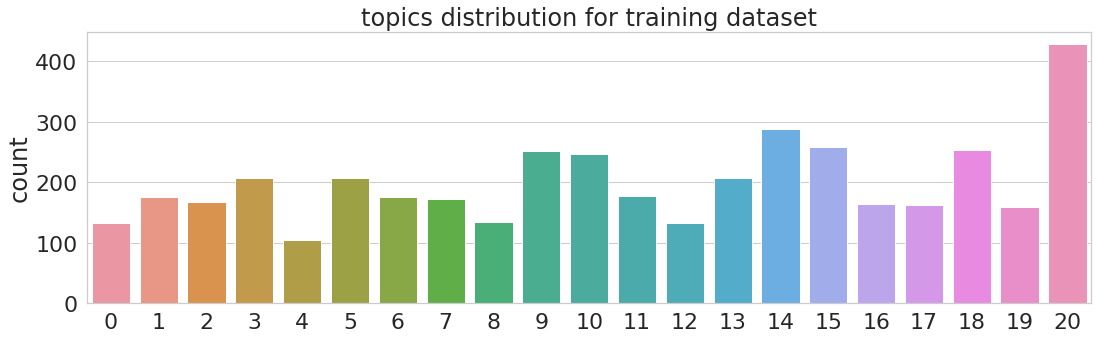

In [53]:
ts_feat = term_matrix[:-test4.shape[0]]
print(ts_feat.shape)
topics_ = lda.transform(ts_feat)

test_topics = []
for topic in topics_:
    test_topics.append(np.argsort(topic)[-1])
    
    
fig, ax = plt.subplots(1,1, figsize=(18,5))    
sns.countplot(test_topics, ax=ax)
ax.set_title("topics distribution for training dataset")

(1773, 1245)


Text(0.5, 1.0, 'topics distribution')

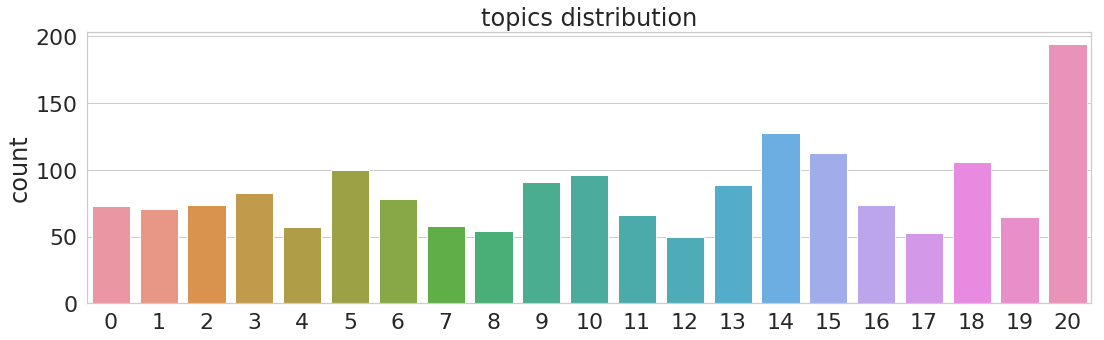

In [52]:
ts_feat = term_matrix[-test4.shape[0]:]
print(ts_feat.shape)
topics_ = lda.transform(ts_feat)

test_topics = []
for topic in topics_:
    test_topics.append(np.argsort(topic)[-1])
    
    
fig, ax = plt.subplots(1,1, figsize=(18,5))    
sns.countplot(test_topics, ax=ax)
ax.set_title("topics distribution")

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    df3[:train4.shape[0]][['text','title']], train4['target'], 
    stratify=train4['target'], 
    test_size=0.25
)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((3157, 2), (3157,), (1053, 2), (1053,))

In [55]:
!pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [58]:
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    words = str(s).lower()#.decode('utf-8')
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

# create sentence vectors using the above function for training and validation set
xtrain_glove = [sent2vec(x) for x in X_train['text']]
xvalid_glove = [sent2vec(x) for x in X_test['text']]
np.array(xtrain_glove).shape, np.array(xvalid_glove).shape

((3157, 300), (1053, 300))

In [61]:
np.concatenate([xtrain_glove, xvalid_glove], axis=0).shape

(4210, 300)

In [66]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=90)
mapping_tsne = tsne.fit_transform(np.concatenate([xtrain_glove, xvalid_glove], axis=0))
mapping_tsne.shape

(4210, 2)

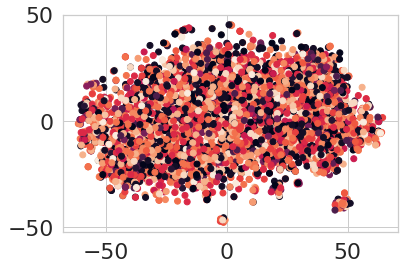

In [65]:
fig, ax = plt.subplots(1,1, figsize=(16,5))
ax.scatter(mapping_tsne[:,0], mapping_tsne[:,1], c=train4['target'])
ax.set_title("class distribution plot of review text using TSNE")

TSNE on embedding of sentence doesn't give any information, if seemed a messy distribution

Text(0.5, 1.0, 'class distribution plot of review text using TSNE')

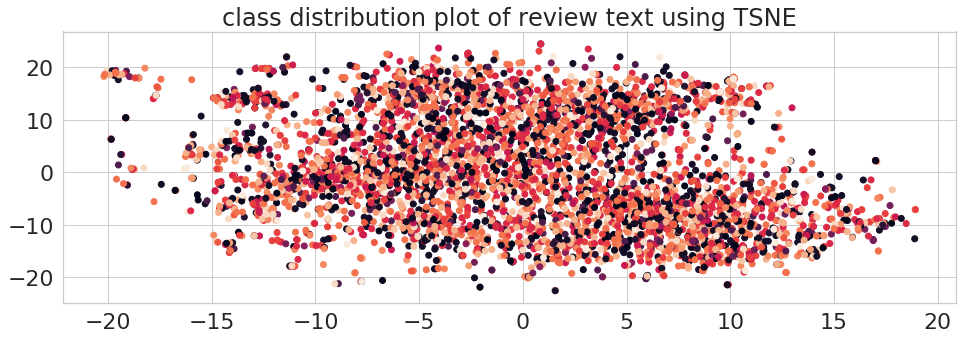

In [67]:
fig, ax = plt.subplots(1,1, figsize=(16,5))
ax.scatter(mapping_tsne[:,0], mapping_tsne[:,1], c=train4['target'])
ax.set_title("class distribution plot of review text using TSNE")

In [0]:
topics_mean = []
for topic in train4['topic'].unique():
    topics_mean.append(mapping_tsne[train4.topic == topic].mean(0))

Text(0.5, 1.0, 'class distribution mean plot of review text')

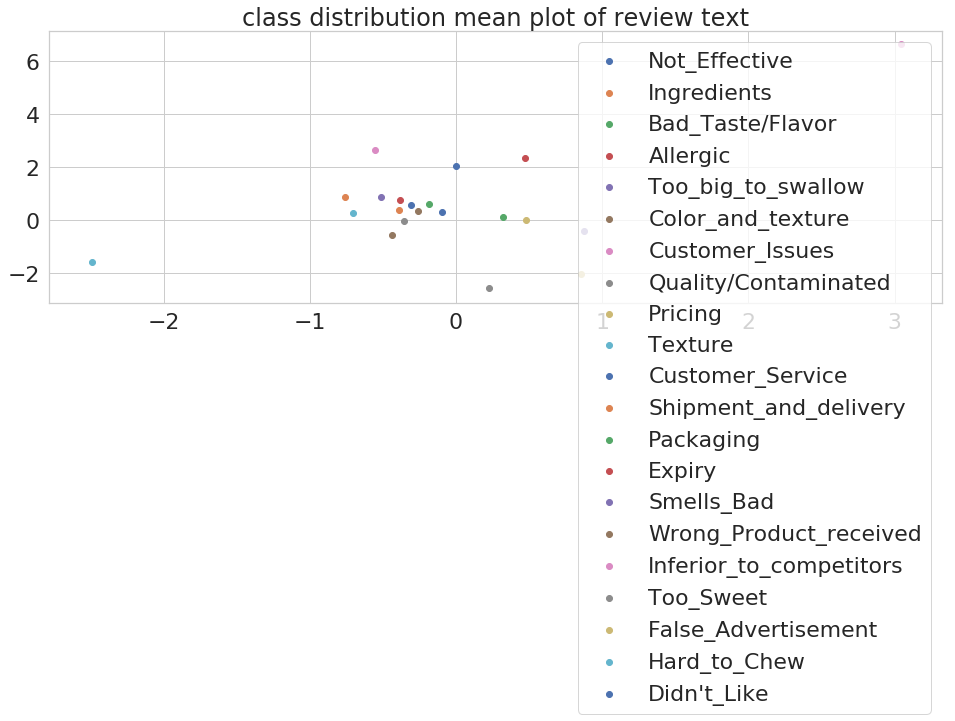

In [78]:
topics_mean = np.array(topics_mean).reshape(-1,2)
fig, ax = plt.subplots(1,1, figsize=(16,5))

for i,topic in enumerate(train4['topic'].unique()):
    ax.scatter(topics_mean[i,0], topics_mean[i,1], label=topic)
#                c=train4['target'].unique(), labels=train4['topic'].unique())
ax.legend()
ax.set_title("class distribution mean plot of review text")

In [79]:
del xtrain_glove, xvalid_glove
gc.collect()

0

In [104]:
df1.shape, df3.shape, df1.columns, df3.columns

((5983, 4),
 (5983, 3),
 Index(['text', 'title', 'topic', 'topic1'], dtype='object'),
 Index(['text', 'title', 'topic'], dtype='object'))

Feature Extraction

1.   Count Vectorizer Fetaures
2.   term Frequency Inverse Document Frequency Features

I extract feature using $4$ ngram as **1,2,3,5**.

In [105]:
print("="*15, "count-vect","="*15)
print("="*15, "text","="*15)
cvect_text_store = []
for ngram in [1,2,3,5]:
#     if ngram < 11 : continue
    cvect = get_count_vectorizer(df3, 'text', ngram)
    print(cvect.shape, end=" ")
    cvect_text_store.append(cvect)
print()
print("="*15, "title","="*15)
cvect_title_store = []
for ngram in [1,2,3,5]:
#     if ngram < 11 : continue
    cvect = get_count_vectorizer(df3, 'title', ngram)
    print(cvect.shape, end=" ")
    cvect_title_store.append(cvect)
    
print()
print("="*30)    
print("="*15, "tfidf","="*15)
print("="*15, "text","="*15)

tfidf_text_store = []
for ngram in [1,2,3,5]:
    tfidf = get_tfidf_feature(df3, 'text', ngram=ngram)
    print(tfidf.shape, end=" ")
    tfidf_text_store.append(tfidf)
    
print()
print("="*15, "title","="*15)
tfidf_title_store = []
for ngram in [1,2,3,5]:
    tfidf = get_tfidf_feature(df3, 'text', ngram=ngram)
    print(tfidf.shape, end=" ")
    tfidf_title_store.append(tfidf)

=============== count-vect ===============
=============== text ===============
(5983, 190846) (5983, 18056) (5983, 8630) (5983, 4380) 
=============== title ===============
(5983, 14131) (5983, 2151) (5983, 1259) (5983, 702) 
=============== tfidf ===============
=============== text ===============
(5983, 3684) (5983, 8192) (5983, 8630) (5983, 8750) 
=============== title ===============
(5983, 3684) (5983, 8192) (5983, 8630) (5983, 8750) 

**Model Building and their Analysis**

1.   Multinomial Naive Bayes Classifier
2.   Logisitic regression
3.   Stochastic Gradient Descent Classifier
4.   Support Vector Machine
5.   OneVsRest and Multiclass

Inference: Multinomial Naive Bayes Classifier performs very well on Using count vectorizer feature, it can be analyzed fro folowing performance analysis.


,Allergic,Bad_Taste/Flavor,Color_and_texture,Customer_Issues,Customer_Service,Didn't_Like,Expiry,False_Advertisement,Hard_to_Chew,Inferior_to_competitors,Ingredients,Not_Effective,Packaging,Pricing,Quality/Contaminated,Shipment_and_delivery,Smells_Bad,Texture,Too_Sweet,Too_big_to_swallow,Wrong_Product_received
0,0.916429,0.884141,0.955366,0.997151,0.941121,0.991453,0.974359,0.990503,0.997151,0.987654,0.953466,0.882241,0.949668,0.973409,0.865147,0.933523,0.971510,0.924976,0.976258,0.947768,0.976258
1,0.925926,0.882241,0.954416,0.996201,0.939221,0.990503,0.985755,0.988604,0.998101,0.989554,0.952517,0.908832,0.933523,0.968661,0.883191,0.934473,0.968661,0.927825,0.974359,0.953466,0.981007
2,0.917379,0.886040,0.966762,0.996201,0.941121,0.991453,0.987654,0.990503,0.997151,0.987654,0.956315,0.903134,0.927825,0.967711,0.865147,0.941121,0.974359,0.934473,0.975309,0.966762,0.984805
3,0.905983,0.879392,0.946819,0.997151,0.932574,0.992403,0.992403,0.992403,0.998101,0.988604,0.953466,0.891738,0.915480,0.969611,0.872745,0.930674,0.966762,0.932574,0.972460,0.965812,0.976258


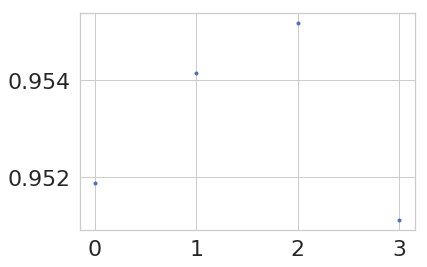

In [106]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split    

acc_table = []

for i, data in enumerate(cvect_text_store):
    train_  = data[:train4.shape[0]]
    target_ = l_table[:train4.shape[0]]
    
    accs = []
    for cls in target_.columns:
        
        X_train, X_test, Y_train, Y_test = train_test_split(
            train_, target_[cls], 
            stratify=target_[cls], 
            test_size=0.25
        )
        clf = MultinomialNB().fit(X_train, Y_train)
        score = clf.score(X_test, Y_test)
#         print('tfidf {:<25} acc: {:.4f}'.format(cls, score))
        accs.append(score)
    acc_table.append(accs)
    
acc_table = pd.DataFrame(data=acc_table, columns=l_table.columns)
plt.plot(acc_table.apply(lambda x: np.mean(x), axis=1), '.')
plt.title("Classification score using count-vect feature on text")

Text(0.5, 1.0, 'Classification score using count-vect feature on titles')

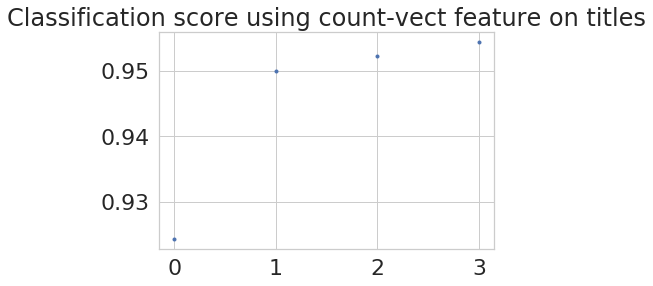

In [85]:
acc_table = []

for i, data in enumerate(cvect_title_store):
    train_  = data[:train1.shape[0]]
    target_ = l_table[:train1.shape[0]]
    
    accs = []
    for cls in target_.columns:
        
        X_train, X_test, Y_train, Y_test = train_test_split(
            train_, target_[cls], 
            stratify=target_[cls], 
            test_size=0.25
        )
        clf = MultinomialNB().fit(X_train, Y_train)
        score = clf.score(X_test, Y_test)
#         print('tfidf {:<25} acc: {:.4f}'.format(cls, score))
        accs.append(score)
    acc_table.append(accs)
    
acc_table = pd.DataFrame(data=acc_table, columns=l_table.columns)
plt.plot(acc_table.apply(lambda x: np.mean(x), axis=1), '.')
plt.title("Classification score using count-vect feature on titles")

Text(0.5, 1.0, 'Classification score using tfidf feature on title')

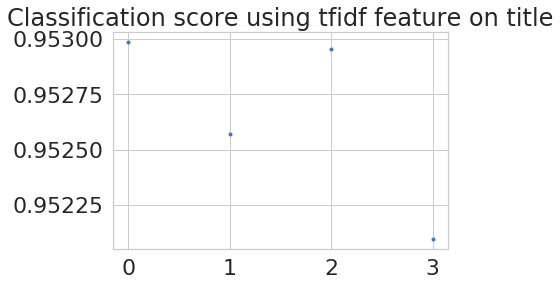

In [86]:
acc_table = []

for i, data in enumerate(tfidf_title_store):
    train_  = data[:train1.shape[0]]
    target_ = l_table[:train1.shape[0]]
    
    accs = []
    for cls in target_.columns:
        
        X_train, X_test, Y_train, Y_test = train_test_split(
            train_, target_[cls], 
            stratify=target_[cls], 
            test_size=0.25
        )
        clf = MultinomialNB().fit(X_train, Y_train)
        score = clf.score(X_test, Y_test)
#         print('tfidf {:<25} acc: {:.4f}'.format(cls, score))
        accs.append(score)
    acc_table.append(accs)
    
acc_table = pd.DataFrame(data=acc_table, columns=l_table.columns)
plt.plot(acc_table.apply(lambda x: np.mean(x), axis=1), '.')
plt.title("Classification score using tfidf feature on title")

Text(0.5, 1.0, 'Classification score using tfidf feature on text')

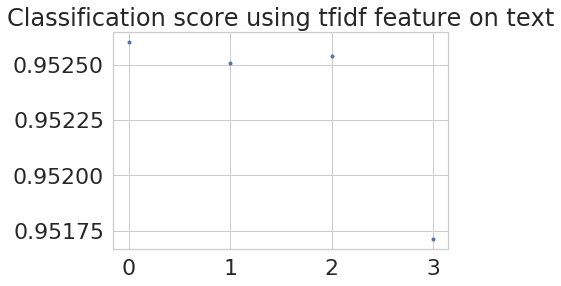

In [87]:
acc_table = []

for i, data in enumerate(tfidf_text_store):
    train_  = data[:train1.shape[0]]
    target_ = l_table[:train1.shape[0]]
    
    accs = []
    for cls in target_.columns:
        
        X_train, X_test, Y_train, Y_test = train_test_split(
            train_, target_[cls], 
            stratify=target_[cls], 
            test_size=0.25
        )
        clf = MultinomialNB().fit(X_train, Y_train)
        score = clf.score(X_test, Y_test)
#         print('tfidf {:<25} acc: {:.4f}'.format(cls, score))
        accs.append(score)
    acc_table.append(accs)
    
acc_table = pd.DataFrame(data=acc_table, columns=l_table.columns)
plt.plot(acc_table.apply(lambda x: np.mean(x), axis=1), '.')
plt.title("Classification score using tfidf feature on text")

Text(0.5, 1.0, 'Logistic Regression score using tfidf feature on text')

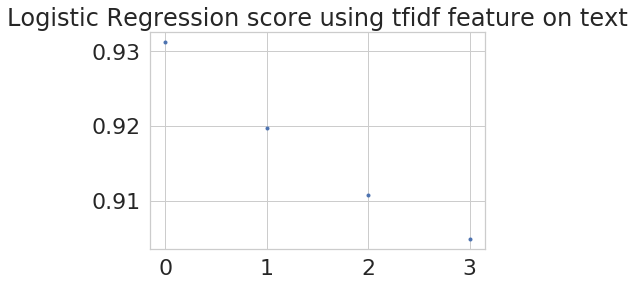

In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split    


acc_table = []
clf = LogisticRegression(penalty='l2', dual=False, 
    C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
    random_state=1234, max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)

for i, data in enumerate(cvect_title_store):
    train_  = data[:train2.shape[0]]
    target_ = l_table[:train2.shape[0]]
    
    accs = []
    for cls in target_.columns:
        
        X_train, X_test, Y_train, Y_test = train_test_split(
            train_, target_[cls], 
            stratify=target_[cls], 
            test_size=0.25
        )
        clf.fit(X_train, Y_train)
        score = clf.score(X_test, Y_test)
#         print('tfidf {:<25} acc: {:.4f}'.format(cls, score))
        accs.append(score)
    acc_table.append(accs)
    
acc_table = pd.DataFrame(data=acc_table, columns=l_table.columns)
plt.plot(acc_table.apply(lambda x: np.mean(x), axis=1), '.')
plt.title("Logistic Regression score using count vect feature on text")

Text(0.5, 1.0, 'Logistic Regression score using tfidf feature on text')

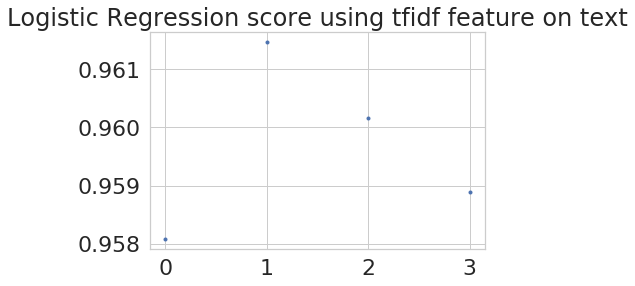

In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split    


acc_table = []
clf = LogisticRegression(penalty='l2', dual=False, 
    C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
    random_state=1234, max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)

for i, data in enumerate(tfidf_text_store):
    train_  = data[:train2.shape[0]]
    target_ = l_table[:train2.shape[0]]
    
    accs = []
    for cls in target_.columns:
        
        X_train, X_test, Y_train, Y_test = train_test_split(
            train_, target_[cls], 
            stratify=target_[cls], 
            test_size=0.25
        )
        clf.fit(X_train, Y_train)
        score = clf.score(X_test, Y_test)
#         print('tfidf {:<25} acc: {:.4f}'.format(cls, score))
        accs.append(score)
    acc_table.append(accs)
    
# acc_table.columns = l_table.columns
acc_table = pd.DataFrame(data=acc_table, columns=l_table.columns)
plt.plot(acc_table.apply(lambda x: np.mean(x), axis=1), '.')
plt.title("Logistic Regression score using tfidf feature on text")

Text(0.5, 1.0, 'Logistic Regression score using tfidf feature on title')

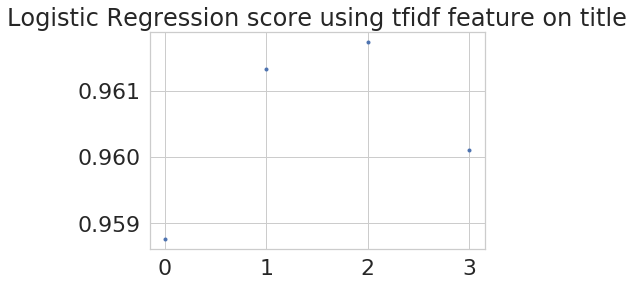

In [89]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split    


acc_table = []
clf = LogisticRegression(penalty='l2', dual=False, 
    C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
    random_state=1234, max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)

for i, data in enumerate(tfidf_title_store):
    train_  = data[:train2.shape[0]]
    target_ = l_table[:train2.shape[0]]
    
    accs = []
    for cls in target_.columns:
        
        X_train, X_test, Y_train, Y_test = train_test_split(
            train_, target_[cls], 
            stratify=target_[cls], 
            test_size=0.25
        )
        clf.fit(X_train, Y_train)
        score = clf.score(X_test, Y_test)
#         print('tfidf {:<25} acc: {:.4f}'.format(cls, score))
        accs.append(score)
    acc_table.append(accs)
    
# acc_table.columns = l_table.columns
acc_table = pd.DataFrame(data=acc_table, columns=l_table.columns)
plt.plot(acc_table.apply(lambda x: np.mean(x), axis=1), '.')
plt.title("Logistic Regression score using tfidf feature on title")

Text(0.5, 1.0, 'SGD classifiers score using tfidf feature on text')

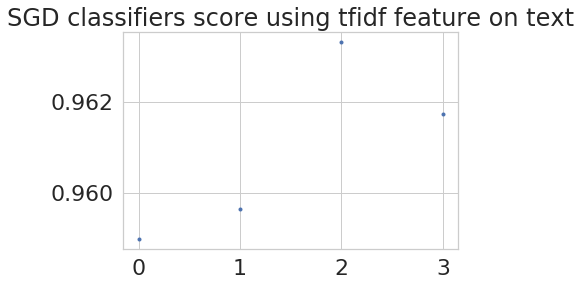

In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split    
from sklearn.linear_model import SGDClassifier
import warnings
warnings.filterwarnings("ignore")

acc_table = []
preds = []
clf = SGDClassifier(loss='log', penalty='elasticnet', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, 
                        max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=4, 
                        random_state=1337, learning_rate='optimal', eta0=0.0, power_t=0.5,
                        early_stopping=True, validation_fraction=0.25, n_iter_no_change=5, 
                        class_weight='balanced', warm_start=False, average=False)

for i, data in enumerate(tfidf_text_store):
    train_  = data[:train2.shape[0]]
    target_ = l_table[:train2.shape[0]]
#     test_   = data[train2.shape[0]:]
    
    
    accs = []
    for cls in target_.columns:
        if(cls == 'topic'): continue
        
        X_train, X_test, Y_train, Y_test = train_test_split(
            train_, target_[cls], 
            stratify=target_[cls], 
            test_size=0.25
        )
        clf.fit(X_train, Y_train)
        score = clf.score(X_test, Y_test)
#         print('tfidf {:<25} acc: {:.4f}'.format(cls, score))
        accs.append(score)
#         pred = clf.predict_proba(test_)
#         print(cls)
#         preds.append(pred[:,1])
    acc_table.append(accs)
    
    
# acc_table.columns = l_table.columns
acc_table = pd.DataFrame(data=acc_table, columns=l_table.columns)
plt.plot(acc_table.apply(lambda x: np.mean(x), axis=1), '.')
plt.title("SGD classifiers score using tfidf feature on text")

Text(0.5, 1.0, 'SGD classifiers score using tfidf feature on title')

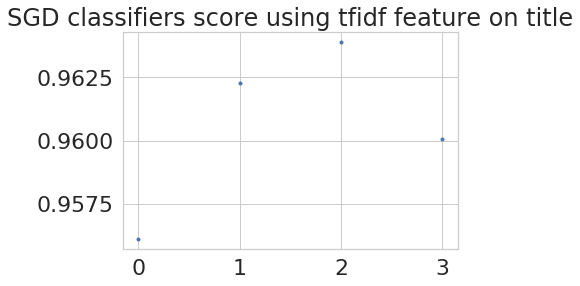

In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split    
from sklearn.linear_model import SGDClassifier
import warnings
warnings.filterwarnings("ignore")

acc_table = []
preds = []
clf = SGDClassifier(loss='log', penalty='elasticnet', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, 
                        max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=4, 
                        random_state=1337, learning_rate='optimal', eta0=0.0, power_t=0.5,
                        early_stopping=True, validation_fraction=0.25, n_iter_no_change=5, 
                        class_weight='balanced', warm_start=False, average=False)

for i, data in enumerate(tfidf_title_store):
    train_  = data[:train2.shape[0]]
    target_ = l_table[:train2.shape[0]]
#     test_   = data[train2.shape[0]:]
    
    
    accs = []
    for cls in target_.columns:
        if(cls == 'topic'): continue
        
        X_train, X_test, Y_train, Y_test = train_test_split(
            train_, target_[cls], 
            stratify=target_[cls], 
            test_size=0.25
        )
        clf.fit(X_train, Y_train)
        score = clf.score(X_test, Y_test)
#         print('tfidf {:<25} acc: {:.4f}'.format(cls, score))
        accs.append(score)
#         pred = clf.predict_proba(test_)
#         print(cls)
#         preds.append(pred[:,1])
    acc_table.append(accs)
    
    
# acc_table.columns = l_table.columns
acc_table = pd.DataFrame(data=acc_table, columns=l_table.columns)
plt.plot(acc_table.apply(lambda x: np.mean(x), axis=1), '.')
plt.title("SGD classifiers score using tfidf feature on title")

Let's build some tree based model on top of SVD feature of text data

In [96]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((3157, 8750), (1053, 8750), (3157,), (1053,))

In [107]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split    
import warnings
warnings.filterwarnings("ignore")

logistic_reg = LogisticRegression(penalty='l2', dual=False, 
    C=0.1, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
    random_state=1234, max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)

for i, data in enumerate(tfidf_text_store):
    train_ = data[:train4.shape[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(
        train_, train4['target'], 
        stratify=train4['target'], 
        test_size=0.25
    )
    clf = logistic_reg.fit(X_train, Y_train)
#     print("log-reg "+str(i), clf.score(X_test, Y_test))
    print('tfidf {:<10} acc: {:.4f}'.format(str(i), clf.score(X_test, Y_test)))

print("="*30)
for i, data in enumerate(cvect_text_store):
    train_ = data[:train4.shape[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(
        train_, train4['target'], 
        stratify=train4['target'], 
        test_size=0.25
    )
    clf = logistic_reg.fit(X_train, Y_train)
#     print("log-reg "+str(i), clf.score(X_test, Y_test))
    print('cvect {:<10} acc: {:.4f}'.format(str(i), clf.score(X_test, Y_test)))

tfidf 0          acc: 0.5916
tfidf 1          acc: 0.6249
tfidf 2          acc: 0.6002
tfidf 3          acc: 0.6277
count-vect 0          acc: 0.6429
count-vect 1          acc: 0.6524
count-vect 2          acc: 0.6410
count-vect 3          acc: 0.6277


In [113]:
data = cvect_text_store[1]
train_ = data[:train4.shape[0]]
X_train, X_test, Y_train, Y_test = train_test_split(
    train_, train4['target'], 
    stratify=train4['target'], 
    test_size=0.25
)
clf = logistic_reg.fit(X_train, Y_train)
#     print("log-reg "+str(i), clf.score(X_test, Y_test))
print('count-vect {:<10} acc: {:.4f}'.format(str(i), clf.score(X_test, Y_test)))

test_ = data[train4.shape[0]:]
pred_log = clf.predict(test_)
print(pred_log.shape)


test4.reset_index(drop=True)
test4['topic'] = pred_log
final1 = pd.merge(test1[['text','title','save_text','save_title']], test4, how='left', on=['text','title'])
final1['target'] = final1['topic'].apply(lambda x: cl_map_inv[x])
final1 = final1[['save_text','save_title','target']]
final1.columns = sub.columns
print(final1.shape)

if not os.path.exists('submission'):
    os.makedirs('submission')
final1.to_csv('submission/cvect_log_reg.csv',index=None)
print("saved successfully")

count-vect 0          acc: 0.6458
(1773,)
(2553, 3)
saved successfully


SGD score:  0.5859449192782527
(1773,)
(2553, 3)
saved successfully


Text(0.5, 1.0, 'Error Analysis on validation dataset')

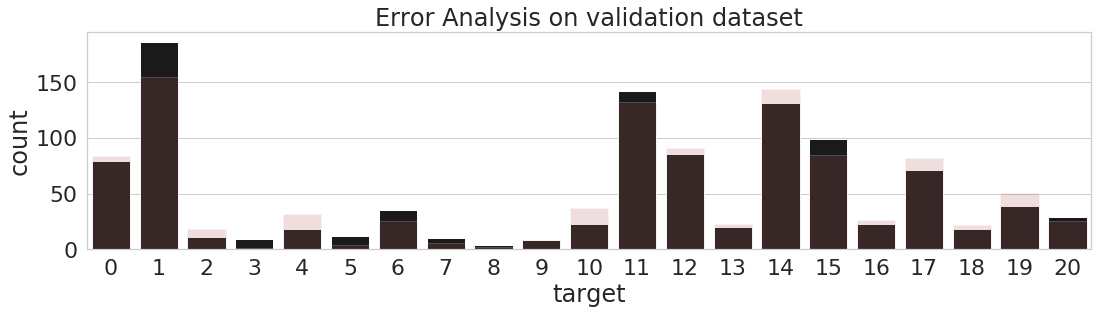

In [123]:
from sklearn.linear_model import SGDClassifier

data = cvect_text_store[1]
train_ = data[:train4.shape[0]]
X_train, X_test, Y_train, Y_test = train_test_split(
    train_, train4['target'], 
    stratify=train4['target'], 
    test_size=0.25
)

sgd_clf = SGDClassifier(loss='log', penalty='elasticnet', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, 
                        max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=4, 
                        random_state=1337, learning_rate='optimal', eta0=0.0, power_t=0.5,
                        early_stopping=True, validation_fraction=0.25, n_iter_no_change=5, 
                        class_weight='balanced', warm_start=False, average=False)
sgd_clf.fit(X_train, Y_train)
print("SGD score: ", sgd_clf.score(X_test, Y_test))

test_ = data[train4.shape[0]:]
pred_sgd = sgd_clf.predict(test_)
print(pred_sgd.shape)


test4.reset_index(drop=True)
test4['topic'] = pred_sgd
final1 = pd.merge(test1[['text','title','save_text','save_title']], test4, how='left', on=['text','title'])
final1['target'] = final1['topic'].apply(lambda x: cl_map_inv[x])
final1 = final1[['save_text','save_title','target']]
final1.columns = sub.columns
print(final1.shape)

if not os.path.exists('submission'):
    os.makedirs('submission')
final1.to_csv('submission/cvect_sgd_clf.csv',index=None)
print("saved successfully")

#######


fig, ax = plt.subplots(1,1, figsize=(18, 4))
sns.countplot(pred, color='k', ax=ax)
sns.countplot(Y_test, color='r', ax=ax, alpha=0.2)
ax.set_title("Error Analysis on validation dataset")


In [121]:
for i, data in enumerate(tfidf_text_store):
    train_ = data[:train4.shape[0]]
    X_train, X_test, Y_train, Y_test = train_test_split(
        train_, train4['target'], 
        stratify=train4['target'], 
        test_size=0.25
    )
    
    sgd_clf = SGDClassifier(loss='log', penalty='elasticnet', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, 
                        max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=4, 
                        random_state=1337, learning_rate='optimal', eta0=0.0, power_t=0.5,
                        early_stopping=True, validation_fraction=0.25, n_iter_no_change=5, 
                        class_weight='balanced', warm_start=False, average=False)
    sgd_clf.fit(X_train, Y_train)
#     sgd_clf.score(X_test, Y_test)

#     clf = logistic_reg.fit(X_train, Y_train)
#     print("log-reg "+str(i), clf.score(X_test, Y_test))
    print('tfidf {:<10} acc: {:.4f}'.format(str(i), sgd_clf.score(X_test, Y_test)))

tfidf 0          acc: 0.6657
tfidf 1          acc: 0.6524
tfidf 2          acc: 0.6857
tfidf 3          acc: 0.6695


SGD score:  0.6590693257359924
(1773,)
(2553, 3)
saved successfully


Text(0.5, 1.0, 'Error Analysis of model on tfidf feature on validation dataset')

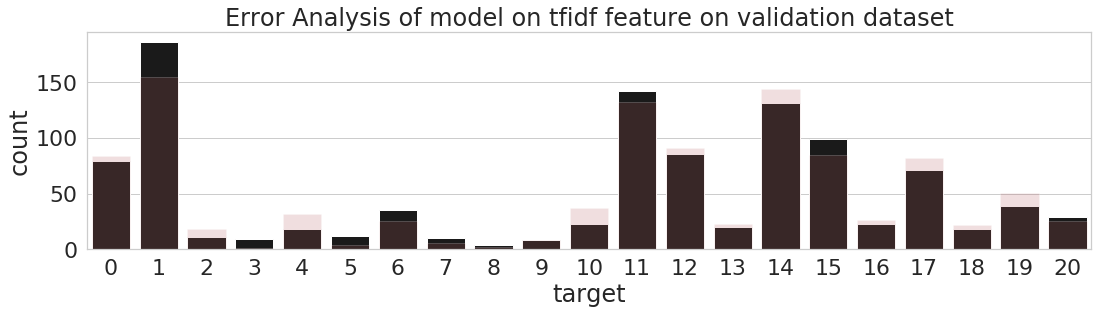

In [124]:
from sklearn.linear_model import SGDClassifier

data = tfidf_text_store[2]
train_ = data[:train4.shape[0]]
X_train, X_test, Y_train, Y_test = train_test_split(
    train_, train4['target'], 
    stratify=train4['target'], 
    test_size=0.25
)

sgd_clf = SGDClassifier(loss='log', penalty='elasticnet', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, 
                        max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=4, 
                        random_state=1337, learning_rate='optimal', eta0=0.0, power_t=0.5,
                        early_stopping=True, validation_fraction=0.25, n_iter_no_change=5, 
                        class_weight='balanced', warm_start=False, average=False)
sgd_clf.fit(X_train, Y_train)
print("SGD score: ", sgd_clf.score(X_test, Y_test))

test_ = data[train4.shape[0]:]
pred_sgd1 = sgd_clf.predict(test_)
print(pred_sgd1.shape)


test4.reset_index(drop=True)
test4['topic'] = pred_sgd1
final1 = pd.merge(test1[['text','title','save_text','save_title']], test4, how='left', on=['text','title'])
final1['target'] = final1['topic'].apply(lambda x: cl_map_inv[x])
final1 = final1[['save_text','save_title','target']]
final1.columns = sub.columns
print(final1.shape)

if not os.path.exists('submission'):
    os.makedirs('submission')
final1.to_csv('submission/tfidf_sgd_clf.csv',index=None)
print("saved successfully")

#######


fig, ax = plt.subplots(1,1, figsize=(18, 4))
sns.countplot(pred, color='k', ax=ax)
sns.countplot(Y_test, color='r', ax=ax, alpha=0.2)
ax.set_title("Error Analysis of model on tfidf feature on validation dataset")


**Build SVD Feature on TFIDF Feature**

1.     Run XGBoost Tree
2.     Support Vector Machine

We use Multiclass-Log-loss on these model, and also check **Top-3 Accuracy** performance.

In [127]:
kuch_title1 = tfidf_feature(train4, test4, 'title', min_df=3, analyzer='word', 
                  token_pattern=r'\w{1,}', ngram=2, stopwords='english', 
                  n_component=75, decom_flag=True, which_method='svd', 
                  max_features=None, feat_col_name='svd_title1')

kuch_text1 = tfidf_feature(train4, test4, 'text', min_df=3, analyzer='word', 
                  token_pattern=r'\w{1,}', ngram=2, stopwords='english', 
                  n_component=150, decom_flag=True, which_method='svd', 
                  max_features=None, feat_col_name='svd_text1')


train_all = pd.concat([kuch_title1[0], kuch_text1[0]], axis=1)
test_all  = pd.concat([kuch_title1[1], kuch_text1[1]], axis=1)
print(train_all.shape, test_all.shape)


===============  done  ===============
===============  done  ===============
(4210, 225) (1773, 225)


In [0]:
def top_n_accuracy(truths, preds, n):
    best_n = np.argsort(preds, axis=1)[:,-n:]
#     ts = np.argmax(truths, axis=1)
    ts = truths
    success = 0
    for t, p in zip(ts, best_n):
        if t in p:
            success += 1
    return float(success)/preds.shape[0]



In [0]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """ Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

In [133]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

X_train, X_test, Y_train, Y_test = train_test_split(
    train_all, train4['target'], 
    stratify  = train4['target'], 
    test_size = 0.25
)
print(X_train.shape, Y_train.shape)


clf = xgb.XGBClassifier(max_depth=4, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=4, learning_rate=0.1)
clf.fit(X_train, Y_train)
predictions = clf.predict_proba(X_test)

print ("logloss: %0.3f " % multiclass_logloss(Y_test, predictions))
score = accuracy_score(Y_test, np.argmax(predictions, axis=1))
print( "  auc = ", score )
print(top_n_accuracy(Y_test, predictions, 3))
print("="*60)

logloss: 1.224 
  auc =  0.654320987654321
0.8641975308641975


In [135]:
pred_xgb1 = clf.predict(test_all)
print(pred_xgb1.shape)

test4.reset_index(drop=True)
test4['topic'] = pred_xgb1
final1 = pd.merge(test1[['text','title','save_text','save_title']], test4, how='left', on=['text','title'])
final1['target'] = final1['topic'].apply(lambda x: cl_map_inv[x])
final1 = final1[['save_text','save_title','target']]
final1.columns = sub.columns
print(final1.shape)

if not os.path.exists('submission'):
    os.makedirs('submission')
final1.to_csv('submission/tfidf_xgb1.csv',index=None)
print("saved successfully")


(1773,)
(2553, 3)
saved successfully


In [137]:
from sklearn.preprocessing import StandardScaler
scl = StandardScaler()
scl.fit(train_all)
train_all = scl.transform(train_all)

from sklearn.metrics import accuracy_score

X_train, X_test, Y_train, Y_test = train_test_split(
    train_all, train4['target'], 
    stratify  = train4['target'], 
    test_size = 0.25
)
print(X_train.shape, Y_train.shape)


clf = xgb.XGBClassifier(max_depth=5, n_estimators=200, colsample_bytree=0.7, 
                        subsample=0.7, nthread=8, learning_rate=0.1)
clf.fit(X_train, Y_train)
predictions = clf.predict_proba(X_test)

print ("logloss: %0.3f " % multiclass_logloss(Y_test, predictions))
score = accuracy_score(Y_test, np.argmax(predictions, axis=1))
print( "  auc = ", score )
print(top_n_accuracy(Y_test, predictions, 3))
print("="*60)

# pred_xgb2 = clf.predict(test_all)
# print(pred_xgb2.shape)

# test4.reset_index(drop=True)
# test4['topic'] = pred_xgb2
# final1 = pd.merge(test1[['text','title','save_text','save_title']], test4, how='left', on=['text','title'])
# final1['target'] = final1['topic'].apply(lambda x: cl_map_inv[x])
# final1 = final1[['save_text','save_title','target']]
# final1.columns = sub.columns
# print(final1.shape)

# if not os.path.exists('submission'):
#     os.makedirs('submission')
# final1.to_csv('submission/tfidf_xgb2.csv',index=None)
# print("saved successfully")


logloss: 1.188 
  auc =  0.6676163342830009
0.8660968660968661


Deep Learning Based Model

1.   Mutliclass Classification (Tranformer Model)
2.   Multilabel Classification



In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(
    train4[['text','title']], train4['target'], 
    stratify  = train4['target'], 
    test_size = 0.25
)

In [138]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text


Using TensorFlow backend.


In [0]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras import Model

from keras.layers import Bidirectional, CuDNNLSTM, LSTM, CuDNNGRU, GRU, Embedding
from keras.layers import Dense, Input, Dropout, Activation, Conv1D, Flatten, Concatenate
from keras.layers import SpatialDropout1D, Dropout, GlobalMaxPooling1D, MaxPooling1D

from keras.regularizers import l2

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping,ReduceLROnPlateau


In [0]:
from keras.engine.topology import Layer
from keras import backend as K
from keras import initializers, regularizers, constraints, optimizers, layers
class Attention(Layer):
    def __init__(self, step_dim, W_regularizer=None, b_regularizer=None, W_constraint=None, b_constraint=None, bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias: eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True)+K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim


In [143]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 128
max_len2 = 17

token.fit_on_texts(list(X_train['text']) + list(X_test['text']))
xtrain_seq = token.texts_to_sequences(X_train['text'])
xvalid_seq = token.texts_to_sequences(X_test['text'])
xtest_seq  = token.texts_to_sequences(test4['text'])

# zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)
xtest_pad  = sequence.pad_sequences(xtest_seq, maxlen=max_len)

word_index = token.word_index

# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

        
# using keras tokenizer here
token1 = text.Tokenizer(num_words=None)

token1.fit_on_texts(list(X_train['title']) + list(X_test['title']))
xtrain_seq1 = token1.texts_to_sequences(X_train['title'])
xvalid_seq1 = token1.texts_to_sequences(X_test['title'])
xtest_seq1  = token1.texts_to_sequences(test4['title'])

# zero pad the sequences
xtrain_pad1 = sequence.pad_sequences(xtrain_seq1, maxlen=max_len2)
xvalid_pad1 = sequence.pad_sequences(xvalid_seq1, maxlen=max_len2)
xtest_pad1  = sequence.pad_sequences(xtest_seq1, maxlen=max_len2)

word_index1 = token1.word_index

# create an embedding matrix for the words we have in the dataset
embedding_matrix1 = np.zeros((len(word_index1) + 1, 300))
for word, i in tqdm(word_index1.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix1[i] = embedding_vector

        
        
# ytrain_enc = np_utils.to_categorical(Y_train, num_classes=21)
# yvalid_enc = np_utils.to_categorical(Y_test, num_classes=21)

xtrain_pad.shape, xvalid_pad.shape, xtest_pad.shape, xtrain_pad1.shape, xvalid_pad1.shape, xtest_pad1.shape



100%|██████████| 2367/2367 [00:00<00:00, 206097.39it/s]


((3157, 128), (1053, 128), (1773, 128), (3157, 17), (1053, 17), (1773, 17))

In [0]:
ytrain_enc = np_utils.to_categorical(Y_train, num_classes=21)
yvalid_enc = np_utils.to_categorical(Y_test, num_classes=21)


**Transformer-Based (Attention Model) Architecture"

In [144]:
try:
    del model_comp
    gc.collect()
except:
    print("no model previously")
    

# GRU with glove embeddings and two dense layers
max_len2 = 17
inp1 = Input(shape=(max_len,))
inp2 = Input(shape=(max_len2,))

x1 = Embedding(  len(word_index) + 1,
                 300,
                 weights=[embedding_matrix],
                 input_length=max_len,
                 trainable=False)(inp1)
x2 = Embedding(  len(word_index1) + 1,
                 300,
                 weights=[embedding_matrix1],
                 input_length=max_len2,
                 trainable=False)(inp2)

x1 = SpatialDropout1D(0.3)(x1)
x2 = SpatialDropout1D(0.3)(x2)

x1 = Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(1e-4)))(x1)
# x1 = Bidirectional(LSTM(200, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(1e-4)))(x1)

x2 = Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(1e-4)))(x2)
# x2 = Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(1e-4)))(x2)

x1 = Attention(max_len)(x1)
x2 = Attention(max_len2)(x2)

x1 = Dense(756, activation='relu', kernel_regularizer=l2(1e-4))(x1)
x1 = Dropout(0.7)(x1)

x2 = Dense(756, activation='relu', kernel_regularizer=l2(1e-4))(x2)
x2 = Dropout(0.7)(x2)

x = Concatenate(axis=1)([x1,x2])
x = Dense(756, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.7)(x)

x = Dense(21, kernel_regularizer=l2(1e-4))(x)
x = Activation('softmax')(x)

model_comp = Model(input=[inp1, inp2], output=x)
model_comp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_comp.summary()

W0811 16:53:55.137963 139719481202560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0811 16:53:55.183153 139719481202560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0811 16:53:55.192569 139719481202560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0811 16:53:55.209286 139719481202560 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0811 16:53:55.210390 1397194812

no model previously


W0811 16:53:55.593811 139719481202560 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0811 16:53:57.464386 139719481202560 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0811 16:53:57.504821 139719481202560 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0811 16:53:57.546210 139719481202560 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0811 16:53:57.581324 139719481202560 depre

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 17)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 128, 300)     2409600     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 17, 300)      710400      input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dr

In [147]:
epochs = 50
batch_size = 256

reducelr = ReduceLROnPlateau(factor=np.sqrt(0.1), monitor='val_acc', patience=2)
modelcheck = ModelCheckpoint('atten_lstm_small.h5', monitor='val_acc', verbose=0, save_best_only=True, period=2)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

model_comp.fit(
    x=[xtrain_pad, xtrain_pad1], 
    y=ytrain_enc, 
    batch_size=batch_size, 
    epochs=epochs, 
    verbose=1, 
    validation_data=([xvalid_pad, xvalid_pad1], yvalid_enc), 
    callbacks=[reducelr, modelcheck, earlystop]
)

W0811 16:55:21.341273 139719481202560 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 3157 samples, validate on 1053 samples
Epoch 1/50
3157/3157 [==============================] - 48s 15ms/step - loss: 3.1377 - acc: 0.1223 - val_loss: 2.9079 - val_acc: 0.2146
Epoch 2/50
3157/3157 [==============================] - 42s 13ms/step - loss: 2.9166 - acc: 0.1555 - val_loss: 2.7674 - val_acc: 0.2346
Epoch 3/50
3157/3157 [==============================] - 41s 13ms/step - loss: 2.7738 - acc: 0.2239 - val_loss: 2.5779 - val_acc: 0.3067
Epoch 4/50
3157/3157 [==============================] - 41s 13ms/step - loss: 2.5870 - acc: 0.2879 - val_loss: 2.3401 - val_acc: 0.3913
Epoch 5/50
3157/3157 [==============================] - 41s 13ms/step - loss: 2.4070 - acc: 0.3339 - val_loss: 2.1919 - val_acc: 0.4141
Epoch 6/50
3157/3157 [==============================] - 42s 13ms/step - loss: 2.2686 - acc: 0.3811 - val_loss: 2.0772 - val_acc: 0.4539
Epoch 7/50
3157/3157 [==============================] - 41s 13ms/step - loss: 2.1612 - acc: 0.4153 - val_loss: 1.9933 - val_acc: 0.4900


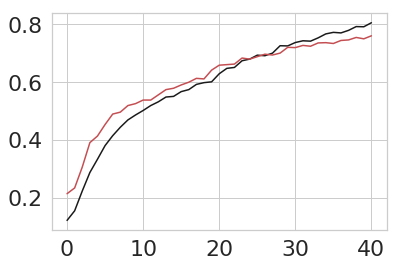

In [149]:
plt.plot(model_comp.history.history['acc'],c='k')
plt.plot(model_comp.history.history['val_acc'],c='r')

In [150]:
pred11 = model_comp.predict([xtest_pad, xtest_pad1], batch_size=250, verbose=1)
pred111 = np.argmax(pred11, axis=1)
print(pred11.shape)

test4.reset_index(drop=True)
test4['topic'] = pred111
final1 = pd.merge(test1[['text','title','save_text','save_title']], test4, how='left', on=['text','title'])
final1['target'] = final1['topic'].apply(lambda x: cl_map_inv[x])
final1 = final1[['save_text','save_title','target']]
final1.columns = sub.columns
print(final1.shape)
if not os.path.exists('submission'):
    os.makedirs('submission')
final1.to_csv('submission/deep_attn_lstm_small.csv',index=None)
print("saved successfully")


1773/1773 [==============================] - 8s 4ms/step
(1773, 21)
(2553, 3)
saved successfully


In [44]:
# try:
#     del model_comp
#     gc.collect()
# except:
#     print("no model previously")
    

# # GRU with glove embeddings and two dense layers
# max_len2 = 17
# inp1 = Input(shape=(max_len,))
# inp2 = Input(shape=(max_len2,))

# x1 = Embedding(  len(word_index) + 1,
#                  300,
#                  weights=[embedding_matrix],
#                  input_length=max_len,
#                  trainable=False)(inp1)
# x2 = Embedding(  len(word_index1) + 1,
#                  300,
#                  weights=[embedding_matrix1],
#                  input_length=max_len2,
#                  trainable=False)(inp2)

# x1 = SpatialDropout1D(0.3)(x1)
# x2 = SpatialDropout1D(0.3)(x2)

# x1 = Bidirectional(LSTM(200, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(1e-4)))(x1)
# x1 = Bidirectional(LSTM(200, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(1e-4)))(x1)

# x2 = Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(1e-4)))(x2)
# x2 = Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(1e-4)))(x2)

# x1 = Attention(max_len)(x1)
# x2 = Attention(max_len2)(x2)

# x1 = Dense(1024, activation='relu', kernel_regularizer=l2(1e-4))(x1)
# x1 = Dropout(0.8)(x1)

# x2 = Dense(1024, activation='relu', kernel_regularizer=l2(1e-4))(x2)
# x2 = Dropout(0.8)(x2)

# x = Concatenate(axis=1)([x1,x2])
# x = Dense(1024, activation='relu', kernel_regularizer=l2(1e-4))(x)
# x = Dropout(0.8)(x)

# x = Dense(21, kernel_regularizer=l2(1e-4))(x)
# x = Activation('softmax')(x)

# model_comp = Model(input=[inp1, inp2], output=x)
# model_comp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# model_comp.summary()

W0811 06:27:28.797589 140037554907008 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0811 06:27:28.841862 140037554907008 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 17)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 128, 300)     2409600     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 17, 300)      710400      input_4[0][0]                    
__________________________________________________________________________________________________
spatial_dr

In [45]:
# epochs = 70
# batch_size = 256

# reducelr = ReduceLROnPlateau(factor=np.sqrt(0.1), monitor='val_loss', patience=2)
# modelcheck = ModelCheckpoint('model_atten_lstm_comb.h5', monitor='val_loss', verbose=0, save_best_only=True, period=2)
# earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

# model_comp.fit(
#     x=[xtrain_pad, xtrain_pad1], 
#     y=ytrain_enc, 
#     batch_size=batch_size, 
#     epochs=epochs, 
#     verbose=1, 
#     validation_data=([xvalid_pad, xvalid_pad1], yvalid_enc), 
#     callbacks=[reducelr, modelcheck, earlystop]
# )

Train on 3157 samples, validate on 1053 samples
Epoch 1/70
3157/3157 [==============================] - 184s 58ms/step - loss: 3.4169 - acc: 0.1121 - val_loss: 3.1909 - val_acc: 0.1472
Epoch 2/70
3157/3157 [==============================] - 166s 52ms/step - loss: 3.1783 - acc: 0.1375 - val_loss: 3.0392 - val_acc: 0.1871
Epoch 3/70
3157/3157 [==============================] - 168s 53ms/step - loss: 3.0187 - acc: 0.1844 - val_loss: 2.8732 - val_acc: 0.2213
Epoch 4/70
3157/3157 [==============================] - 162s 51ms/step - loss: 2.8616 - acc: 0.2354 - val_loss: 2.6935 - val_acc: 0.2868
Epoch 5/70
3157/3157 [==============================] - 169s 54ms/step - loss: 2.7108 - acc: 0.2838 - val_loss: 2.5858 - val_acc: 0.3162
Epoch 6/70
3157/3157 [==============================] - 168s 53ms/step - loss: 2.6068 - acc: 0.3187 - val_loss: 2.5011 - val_acc: 0.3485
Epoch 7/70
3157/3157 [==============================] - 162s 51ms/step - loss: 2.5130 - acc: 0.3643 - val_loss: 2.4137 - val_acc: 

In [54]:
# pred11 = model_comp.predict([xtest_pad, xtest_pad1], batch_size=500, verbose=1)
# pred111 = np.argmax(pred11, axis=1)
# print(pred11.shape)

# test4.reset_index(drop=True)
# test4['topic'] = pred111
# final1 = pd.merge(test1[['text','title','save_text','save_title']], test4, how='left', on=['text','title'])
# final1['target'] = final1['topic'].apply(lambda x: cl_map_inv[x])
# final1 = final1[['save_text','save_title','target']]
# final1.columns = sub.columns
# print(final1.shape)
# if not os.path.exists('submission'):
#     os.make_dirs('submission')
# final1.to_csv('submission/deep_att_lstm.csv',index=None)
# final1.head()

1773/1773 [==============================] - 25s 14ms/step
(1773, 21)
(2553, 3)


,Review Text,Review Title,topic
0,I use chia seed in my protein shakes. These ta...,Bad tast,Quality/Contaminated
1,I use chia seed in my protein shakes. These ta...,Bad tast,Quality/Contaminated
2,Don’t waste your money.,No change. No results.,Not Effective
3,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Ingredients
4,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Ingredients


In [25]:
# try:
#     del model_comp1
#     gc.collect()
# except:
#     print("no model previously")
    

# # GRU with glove embeddings and two dense layers
# max_len2 = 17
# inp1 = Input(shape=(max_len,))
# inp2 = Input(shape=(max_len2,))

# x1 = Embedding(  len(word_index) + 1,
#                  300,
#                  weights=[embedding_matrix],
#                  input_length=max_len,
#                  trainable=False)(inp1)
# x2 = Embedding(  len(word_index1) + 1,
#                  300,
#                  weights=[embedding_matrix1],
#                  input_length=max_len2,
#                  trainable=False)(inp2)

# x1 = SpatialDropout1D(0.3)(x1)
# x2 = SpatialDropout1D(0.3)(x2)

# x1 = Bidirectional(LSTM(120, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(1e-4)))(x1)
# x1 = Bidirectional(LSTM(120, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(1e-4)))(x1)

# x2 = Bidirectional(LSTM(70, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(1e-4)))(x2)
# x2 = Bidirectional(LSTM(70, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(1e-4)))(x2)

# x1 = Attention(max_len)(x1)
# x2 = Attention(max_len2)(x2)

# x1 = Dense(756, activation='relu', kernel_regularizer=l2(1e-4))(x1)
# x1 = Dropout(0.7)(x1)

# x2 = Dense(756, activation='relu', kernel_regularizer=l2(1e-4))(x2)
# x2 = Dropout(0.7)(x2)

# x = Concatenate(axis=1)([x1,x2])
# x = Dense(756, activation='relu', kernel_regularizer=l2(1e-4))(x)
# x = Dropout(0.7)(x)

# x = Dense(21, kernel_regularizer=l2(1e-4))(x)
# x = Activation('sigmoid')(x)

# model_comp1 = Model(input=[inp1, inp2], output=x)
# model_comp1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# model_comp1.summary()

W0811 10:14:19.023206 139968440121216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0811 10:14:19.070110 139968440121216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0811 10:14:19.083018 139968440121216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0811 10:14:19.100563 139968440121216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0811 10:14:19.101979 1399684401

no model previously


W0811 10:14:19.576651 139968440121216 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0811 10:14:23.232602 139968440121216 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0811 10:14:23.272989 139968440121216 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0811 10:14:23.313766 139968440121216 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0811 10:14:23.349565 139968440121216 depre

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 17)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 128, 300)     2409600     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 17, 300)      710400      input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dr

In [28]:
# epochs = 70
# batch_size = 128

# reducelr = ReduceLROnPlateau(factor=np.sqrt(0.1), monitor='val_loss', patience=2)
# modelcheck = ModelCheckpoint('model_atten_lstm_comb1.h5', monitor='val_loss', verbose=0, save_best_only=True, period=2)
# earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

# model_comp1.fit(
#     x=[xtrain_pad, xtrain_pad1], 
#     y=Y_train.values, 
#     batch_size=batch_size, 
#     epochs=epochs, 
#     verbose=1, 
#     validation_data=([xvalid_pad, xvalid_pad1], Y_test.values), 
#     callbacks=[reducelr, modelcheck, earlystop]
# )

Train on 3157 samples, validate on 1053 samples
Epoch 1/70
3157/3157 [==============================] - 103s 33ms/step - loss: 0.6965 - acc: 0.8914 - val_loss: 0.4887 - val_acc: 0.9324
Epoch 2/70
3157/3157 [==============================] - 91s 29ms/step - loss: 0.4425 - acc: 0.9313 - val_loss: 0.3813 - val_acc: 0.9324
Epoch 3/70
3157/3157 [==============================] - 92s 29ms/step - loss: 0.3598 - acc: 0.9336 - val_loss: 0.3201 - val_acc: 0.9361
Epoch 4/70
3157/3157 [==============================] - 92s 29ms/step - loss: 0.3107 - acc: 0.9361 - val_loss: 0.2868 - val_acc: 0.9372
Epoch 5/70
3157/3157 [==============================] - 92s 29ms/step - loss: 0.2844 - acc: 0.9365 - val_loss: 0.2657 - val_acc: 0.9377
Epoch 6/70
3157/3157 [==============================] - 93s 29ms/step - loss: 0.2654 - acc: 0.9366 - val_loss: 0.2505 - val_acc: 0.9380
Epoch 7/70
3157/3157 [==============================] - 92s 29ms/step - loss: 0.2522 - acc: 0.9369 - val_loss: 0.2387 - val_acc: 0.9389

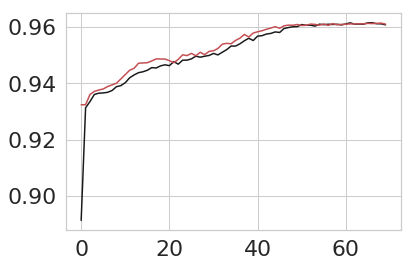

In [30]:
# plt.plot(model_comp1.history.history['acc'],c='k')
# plt.plot(model_comp1.history.history['val_acc'],c='r')

In [224]:
# pred11 = model_comp1.predict([xtest_pad, xtest_pad1], batch_size=250, verbose=1)
# pred111 = np.argmax(pred11, axis=1)
# print(pred11.shape)

# test4.reset_index(drop=True)
# test4['topic'] = pred111
# final1 = pd.merge(test1[['text','title','save_text','save_title']], test4, how='left', on=['text','title'])
# final1['target'] = final1['topic'].apply(lambda x: cl_map_inv[x])
# final1 = final1[['save_text','save_title','target']]
# final1.columns = sub.columns
# print(final1.shape)
# final1.to_csv('deep_att_lstm_multilabel.csv',index=None)
# final1.head()

(1773, 21)
(2553, 3)


,Review Text,Review Title,topic
0,I use chia seed in my protein shakes. These ta...,Bad tast,Quality/Contaminated
1,I use chia seed in my protein shakes. These ta...,Bad tast,Quality/Contaminated
2,Don’t waste your money.,No change. No results.,Not Effective
3,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Allergic
4,I use the book 'Fortify Your Life' by Tieraona...,"Good Vegan Choice, Poor Non Vegan Choice",Allergic


In [35]:
# test['topic'] = 'null'
# gp = test.groupby(['text','title']).agg({
#         "topic": lambda x: " ".join(x.values)
#     })
# test11 = pd.DataFrame(gp.reset_index())
# test11.head()

,text,title,topic
0,"""Stir for 30 seconds until product dissolves.""...",Does Not Dissolve,null
1,"""X Brand"" has failed to deliver what they offe...","The 3-pack does not come with 3, only 1.",null null
2,"""X Brand"" is screwing products. They sent hydr...",Screwed up,null null null
3,"""X Brand"" needs to make sure the top is sealed...",Shipping Issues,null
4,*I bought this when I thought I ran out. I re...,Too expensive for the strength.,null


In [0]:
# test_topics_len = test2['topic'].apply(lambda x: len(x.split(" ")))
# pred111 = []
# for row, len_ in zip(np.argsort(pred11), test_topics_len):
#     pred111.append(row[-len_:])

In [160]:
# pred112 = [list(row) for row in pred111]
# test4['target'] = pred112
# test4.head()

,text,title,topic,target
0,,the sellers did not ship timely and shipment g...,null,[15]
1,absolutely despised these vitamins wanted like...,nope nope nope,null,"[14, 1]"
2,absolutely disgusted the delivery was delivere...,delivery sucked,null,"[12, 15]"
3,absolutely terrible,gross,null,[1]
4,accidentally ordered the one made with sugar a...,sugarfree tastes better,null,[1]


In [214]:
# texts = []
# titles = []
# topics = []
# count = 0
# for row in test4.values:
#     for target in row[-1]:
#         count += 1
#         chut = test11[(test11.text == row[0]) & (test11.title == row[1])].values
# #         , chut['save_title']
#         texts.append(chut[0][2])
# #         texts.append(chut['save_text'])
#         titles.append(chut[0][3])
#         topics.append(cl_map_inv[target])
        
# len(texts), count

(2553, 2553)

In [215]:
# final_sub = pd.DataFrame(data=[texts, titles, topics]).T
# final_sub.columns = sub.columns
# final_sub.head(50)

,Review Text,Review Title,topic
0,0,The sellers didn’t ship timely and shipment go...,Shipment and delivery
1,Absolutely despised these vitamins. I wanted t...,Nope nope nope,Quality/Contaminated
2,Absolutely despised these vitamins. I wanted t...,Nope nope nope,Bad Taste/Flavor
3,Absolutely disgusted by the delivery! It was d...,Delivery sucked,Packaging
4,Absolutely disgusted by the delivery! It was d...,Delivery sucked,Shipment and delivery
5,It’s absolutely terrible,Gross,Bad Taste/Flavor
6,Accidentally ordered the one made with sugar. ...,Sugarfree Tastes Better,Bad Taste/Flavor
7,After 1 hour of taking this I had the worst tu...,TUNNEL VISION and I felt like my head was in a...,Not Effective
8,After 3 months of being stored at the proper t...,Discolored,Not Effective
9,After 3 months of being stored at the proper t...,Discolored,Packaging


In [203]:
# test11 = test1.drop('topic', axis=1)
# test11 =test11.drop_duplicates()
# print(test11.shape)

(1776, 4)


In [0]:
# final_sub.to_csv('sub_multilabel.csv', index=None)

In [222]:
# final_sub.head(25)

,Review Text,Review Title,topic
0,0,The sellers didn’t ship timely and shipment go...,Shipment and delivery
1,Absolutely despised these vitamins. I wanted t...,Nope nope nope,Quality/Contaminated
2,Absolutely despised these vitamins. I wanted t...,Nope nope nope,Bad Taste/Flavor
3,Absolutely disgusted by the delivery! It was d...,Delivery sucked,Packaging
4,Absolutely disgusted by the delivery! It was d...,Delivery sucked,Shipment and delivery
5,It’s absolutely terrible,Gross,Bad Taste/Flavor
6,Accidentally ordered the one made with sugar. ...,Sugarfree Tastes Better,Bad Taste/Flavor
7,After 1 hour of taking this I had the worst tu...,TUNNEL VISION and I felt like my head was in a...,Not Effective
8,After 3 months of being stored at the proper t...,Discolored,Not Effective
9,After 3 months of being stored at the proper t...,Discolored,Packaging


In [0]:
# # pred11 = model_comp.predict([xtest_pad, xtest_pad1], batch_size=250, verbose=1)
# pred111 = np.argmax(pred11, axis=1)
# print(pred11.shape)

# test4.reset_index(drop=True)
# test4['topic'] = pred111
# final1 = pd.merge(test1[['text','title','save_text','save_title']], test4, how='left', on=['text','title'])
# final1['target'] = final1['topic'].apply(lambda x: cl_map_inv[x])
# final1 = final1[['save_text','save_title','target']]
# final1.columns = sub.columns
# print(final1.shape)
# final1.to_csv('submission/deep_att_lstm.csv',index=None)
# final1.head()

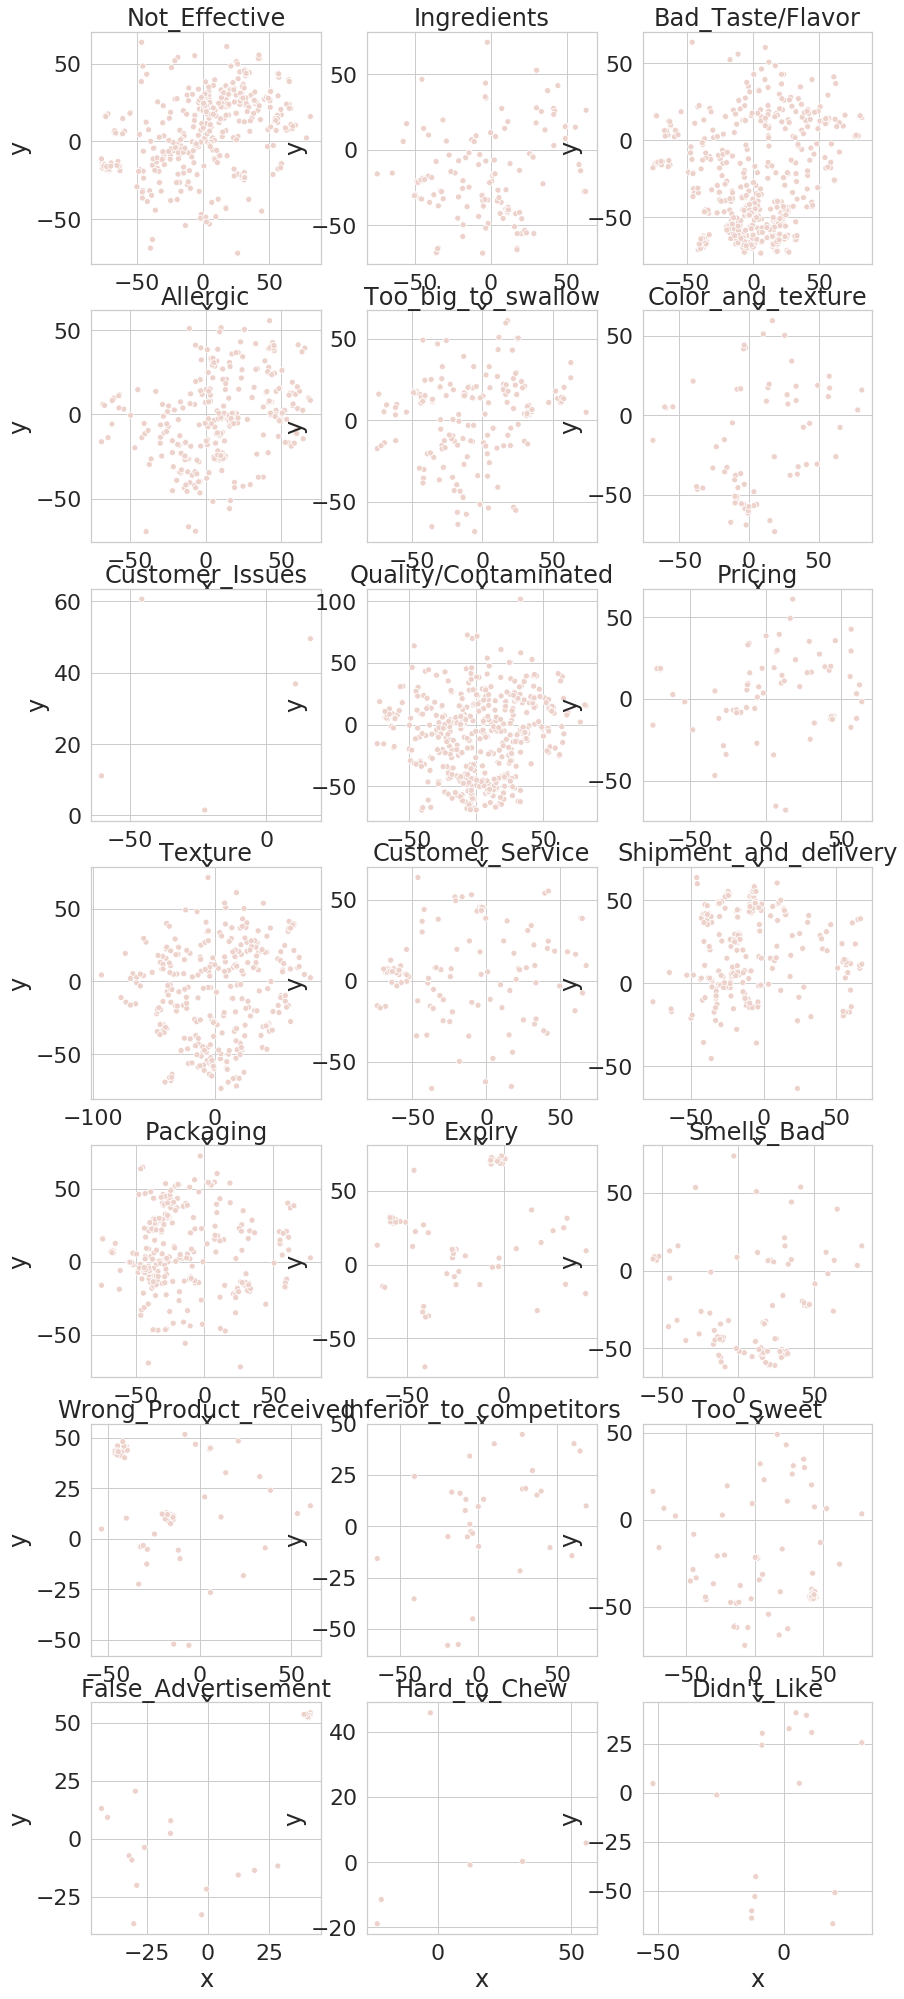

In [122]:
# fig, ax = plt.subplots(7,3,figsize=(14,35))
# axes = ax.flatten()
# topics = list(train4.topic.unique())
# for ax,topic in zip(axes, topics):
#     sns.scatterplot(x='x',y='y',hue='target', c='k', 
#                     data=mapping2[mapping2.topic == topic], 
#                     ax=ax, legend=False)
#     ax.set_title(topic)

# # plt.legend(loc='best')

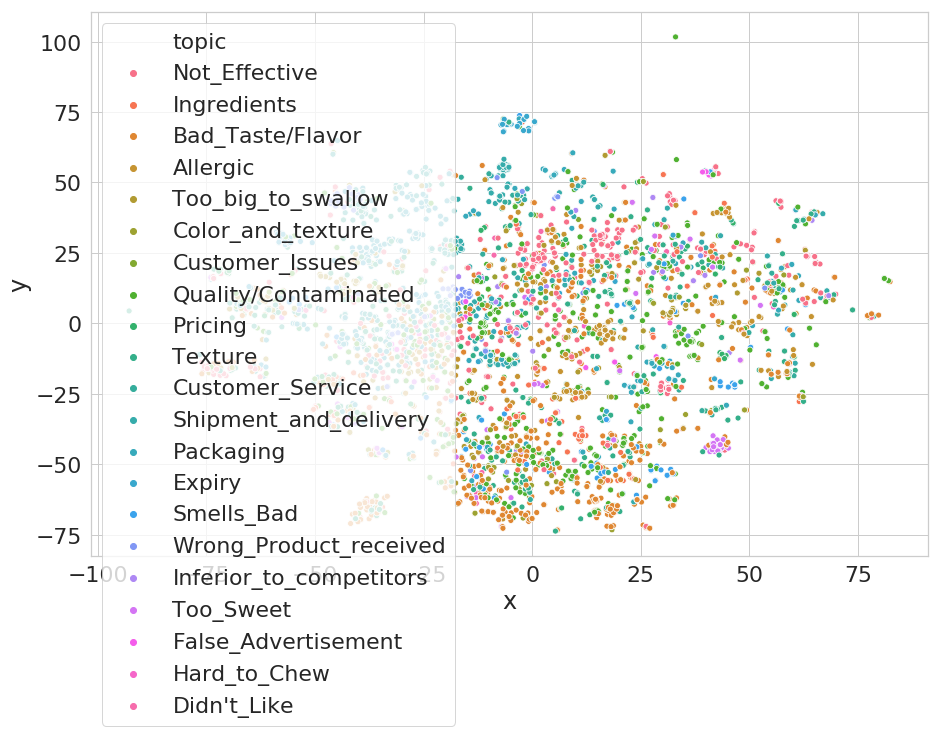

In [115]:
# fig, ax = plt.subplots(1,1,figsize=(15,10))
# sns.scatterplot(x='x',y='y',hue=train4['topic'], data=mapping2, ax=ax, legend='full')
# # plt.legend(loc='best')

In [0]:
# from sklearn.cluster import KMeans
# y_pred = KMeans(n_clusters=21, random_state=1337).fit_predict(mapping_mean)


W0811 09:03:16.939636 140037554907008 legend.py:1289] No handles with labels found to put in legend.


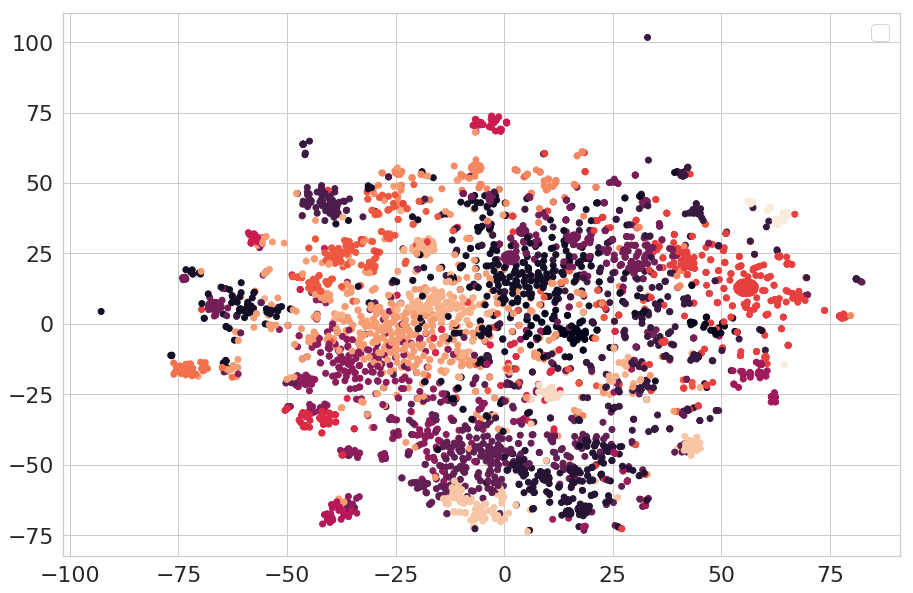

In [114]:
# fig, ax = plt.subplots(1,1,figsize=(15,10))
# # sns.scatterplot(x='x',y='y',hue='target', data=mapping2, ax=ax, legend='full')
# ax.scatter(mapping_tsne[:,0], mapping_tsne[:,1], c=y_pred)
# plt.legend(loc='best')

In [0]:
# cl_mean = []
# for topic in topics:
#     cl_mean.append(mapping_mean[train4.topic == topic].mean(axis=0))

In [0]:
# from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2)
# cl_tsne = tsne.fit_transform(np.array(cl_mean).reshape(-1,300))

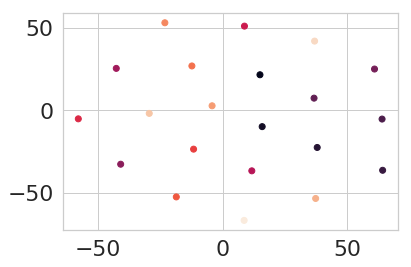

In [156]:
# plt.scatter(cl_tsne[:,0], cl_tsne[:,1], c=range(21))

In [0]:
# from google.colab import files
# files.download('submission/deep_att_lstm.csv')